In [1]:
import jax
print(f"JAX devices: {jax.devices()}")
print(f"Backend: {jax.default_backend()}")
assert jax.default_backend() == "gpu", "gpu not detected!"


JAX devices: [CudaDevice(id=0)]
Backend: gpu


In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad
import jax
import os

import jaxley as jx
import jaxley.optimize.transforms as jt
from jaxley.channels import HH
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import connect

import optax
import time as time

import pandas as pd

### Multi-comp HH model setup

In [3]:
n_post_comp = 15
num_pre = 8
post_idx = num_pre # post cell index inside the network
Nsyn = num_pre

i_delay = 10.0    # ms
i_amp = 0.2   # nA
i_dur = 10.0   # ms
dt = 0.025  # ms
t_max = 50.0   # ms

base_amp = i_amp

syn_post_comp_indices = np.linspace(0, n_post_comp - 1, num_pre).astype(int)

def build_net():
    comp_pre = jx.Compartment()
    branch_pre = jx.Branch(comp_pre, ncomp=1)
    cell_pre = jx.Cell(branch_pre, parents=np.asarray([-1]))

    comp_post = jx.Compartment()
    branch_post = jx.Branch(comp_post, ncomp=n_post_comp)
    cell_post = jx.Cell(branch_post, parents=np.asarray([-1]))

    pre_cells = [cell_pre for _ in range(num_pre)]
    cells = pre_cells + [cell_post]
    net = jx.Network(cells)

    net.insert(HH())

    syn = IonotropicSynapse()
    for pre_i, comp_i in zip(range(num_pre), syn_post_comp_indices):
        connect(
            net.cell(pre_i).branch(0).comp(0),
            net.cell(post_idx).branch(0).comp(int(comp_i)),
            syn,
        )
    return net

def setup_recordings_all(net_obj):
    net_obj.delete_recordings()
    for ci in range(n_post_comp):
        net_obj.cell(post_idx).branch(0).comp(ci).record()
    return net_obj


net_analysis = build_net()


net_analysis = setup_recordings_all(net_analysis)

# net_analysis.IonotropicSynapse.set("IonotropicSynapse_gS", 5e-4) # code to update if needed 
net_analysis.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")
params_true = net_analysis.get_parameters()
print(f"Network: {net_analysis.nodes.shape[0]} compartments, "
      f"{net_analysis.edges.shape[0]} edges")
print(f"Number of synapses = {Nsyn}, syn_post_comp_indices = {syn_post_comp_indices}")




Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Number of newly added trainable parameters: 8. Total number of trainable parameters: 8
Network: 23 compartments, 8 edges
Number of synapses = 8, syn_post_comp_indices = [ 0  2  4  6  8 10 12 14]


In [ ]:
print("node columns:", list(net_analysis.nodes.columns))

cols = [c for c in net_analysis.nodes.columns]

print("showing cols:", cols)
display(net_analysis.nodes[cols].head(15))

In [21]:
print(net_analysis.edges.columns)

Index(['global_edge_index', 'index_within_type', 'pre_index', 'post_index',
       'type', 'type_ind', 'pre_locs', 'post_locs', 'IonotropicSynapse_gS',
       'IonotropicSynapse_e_syn', 'IonotropicSynapse_k_minus',
       'IonotropicSynapse_v_th', 'IonotropicSynapse_delta',
       'IonotropicSynapse_s', 'controlled_by_param'],
      dtype='object')


### Simulation Setup

In [4]:
t_warm = 40    
i_delay_eff = t_warm + i_delay #start
t_max_eff = t_warm + t_max #end
T_keep = int(round(t_max/dt)) + 1
i0 = int(round(t_warm/dt))
print(f"Warmup: t_warm={t_warm} ms, i0={i0}, T_keep={T_keep}, "
      f"total sim = {t_max_eff} ms")

def simulate_analysis(params_phys, pattern):
    amps = base_amp * pattern
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay_eff, i_dur=i_dur,
        i_amp=amps, delta_t=dt, t_max=t_max_eff,
    )
    net_analysis.delete_stimuli()
    data_stimuli = None
    for i in range(num_pre):
        data_stimuli = (
            net_analysis.cell(i).branch(0).loc(0.0)
            .data_stimulate(currents[i], data_stimuli=data_stimuli)
        )
    traces = jx.integrate(net_analysis, params=params_phys,
                          data_stimuli=data_stimuli, delta_t=dt)

    # crop out warmup toreturn clean 0 to 50ms window
    return traces[:, i0:i0 + T_keep]

def simulate_soma(params_phys, pattern):
    return simulate_analysis(params_phys, pattern)[0]   # (T,)

batched_simulate_soma = vmap(simulate_soma, in_axes=(None, 0)) # get many traces at once 

def loss_and_traces(params_phys, pattern, target):
    raw_traces = simulate_analysis(params_phys, pattern)
    soma_pred = raw_traces[0]
    loss = jnp.mean((soma_pred - target) ** 2)
    return loss, raw_traces

_vg_fn = jit(value_and_grad(loss_and_traces, argnums=0, has_aux=True))

def single_trial(params_phys, pattern, target):
    (loss, raw_traces), grads = _vg_fn(params_phys, pattern, target)
    grad_w = grads[0]["IonotropicSynapse_gS"]       # (Nsyn,)
    return grad_w, raw_traces, loss

# batched over patterns (shared params)
batched_vg = jit(jax.vmap(
    jax.value_and_grad(loss_and_traces, argnums=0, has_aux=True),
    in_axes=(None, 0, 0),
))



Warmup: t_warm=40 ms, i0=1600, T_keep=2001, total sim = 90.0 ms


In [6]:
print(f"Params_true = {params_true}")

Params_true = [{'IonotropicSynapse_gS': Array([0.0001, 0.0001, 0.0001], dtype=float64)}]


In [5]:
gS_true = params_true[0]["IonotropicSynapse_gS"]
params_true = [{"IonotropicSynapse_gS": gS_true}]
transform = jx.ParamTransform([
    {"IonotropicSynapse_gS": jt.SigmoidTransform(1e-5, 1e-2)},
])

opt_params_true = transform.inverse(params_true)
key_learn = jax.random.PRNGKey(1)
sigma = 0.05  # 5% lognormal perturbation
gS_learned = jnp.clip(
    gS_true * jnp.exp(sigma * jax.random.normal(key_learn, (Nsyn,))),
    1e-5, 1e-2
)
params_analysis = [{"IonotropicSynapse_gS": gS_learned}]
gS_learned = params_analysis[0]["IonotropicSynapse_gS"]

print("gS_true:", gS_true)
print("gS_learned:", gS_learned)
print(f"max |diff|: {float(jnp.max(jnp.abs(gS_true - gS_learned))):.2e}")



gS_true: [0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001]
gS_learned: [9.42504843e-05 9.94208316e-05 1.00867190e-04 1.04902940e-04
 9.59207643e-05 1.03514370e-04 1.00377964e-04 9.62495051e-05]
max |diff|: 5.75e-06


#### Pattern Visualization

In [6]:
patterns_zero = jnp.zeros(Nsyn,dtype=jnp.float64) # (8, 8)
print(f"\npatterns zero shape: {patterns_zero.shape}")
print(patterns_zero)

targets_zero = batched_simulate_soma(params_true, patterns_zero[None, :]) 
T = targets_zero.shape[1]                                   
t_arr = np.arange(T_keep) * dt

print(f"\ntargets_zero shape: {targets_zero.shape}")
print(f"T = {T},  dt = {dt} ms,  t_max = {t_max} ms")



patterns zero shape: (8,)
[0. 0. 0. 0. 0. 0. 0. 0.]



targets_zero shape: (1, 2001)
T = 2001,  dt = 0.025 ms,  t_max = 50.0 ms


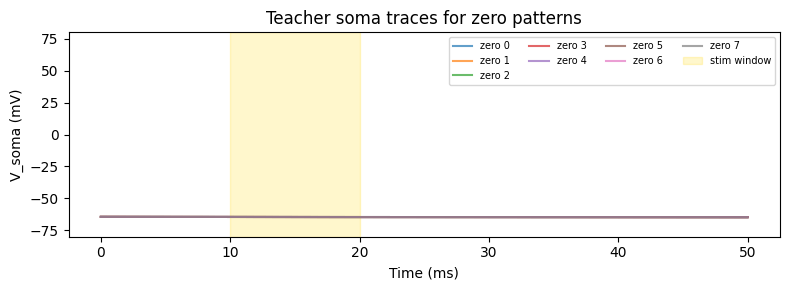

In [7]:
fig, ax = plt.subplots(figsize=(8, 3))
for p in range(Nsyn):
    ax.plot(t_arr, targets_zero[p], alpha=0.7, label=f"zero {p}")
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.2, label="stim window")
ax.set_ylim(-80, 80)
ax.set_xlabel("Time (ms)"); ax.set_ylabel("V_soma (mV)")
ax.set_title("Teacher soma traces for zero patterns")
ax.legend(fontsize=7, ncol=4)
plt.tight_layout(); plt.show()

In [8]:
patterns_onehot = jnp.eye(Nsyn, dtype=jnp.float64)   # (8, 8)
print(f"\npatterns_onehot shape: {patterns_onehot.shape}")
print(patterns_onehot)

targets_onehot = batched_simulate_soma(params_true, patterns_onehot)   # (8, T)
T = targets_onehot.shape[1]                                            # time axis
t_arr = np.arange(T_keep) * dt

print(f"\ntargets_onehot shape: {targets_onehot.shape}")
print(f"T = {T},  dt = {dt} ms,  t_max = {t_max} ms")

print("\n── Gradients (student params vs teacher targets) ──")
for p in range(Nsyn):
    grad_w, raw_traces, loss = single_trial(params_analysis, patterns_onehot[p], targets_onehot[p])
    vmax_err = float(jnp.max(jnp.abs(raw_traces[0] - targets_onehot[p])))
    print(f"pattern {p}: loss={float(loss):.3e}  max|v-target|={vmax_err:.3e}  grad={grad_w}")


patterns_onehot shape: (8, 8)
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]

targets_onehot shape: (8, 2001)
T = 2001,  dt = 0.025 ms,  t_max = 50.0 ms

── Gradients (student params vs teacher targets) ──
pattern 0: loss=7.718e-03  max|v-target|=2.375e-01  grad=[-2.69184291e+03 -1.07301620e+02 -5.21085721e+01 -2.55214582e+01
 -1.26293885e+01 -6.41332089e+00 -3.55899648e+00 -2.55471775e+00]
pattern 1: loss=1.696e-04  max|v-target|=2.438e-02  grad=[ -44.10251022 -191.47243512   -9.85663855   -4.78027774   -2.33160813
   -1.15590997   -0.61774702   -0.42877813]
pattern 2: loss=6.556e-05  max|v-target|=1.287e-02  grad=[-27.12856798 -12.93240105 -25.3945251   -2.92015668  -1.40168958
  -0.67804507  -0.34864315  -0.23338191]
pattern 3: loss=1.208e-04  max|v-target|=3.317e-02  grad=[-11.86792118  -5.77765455  -2.83841327  3

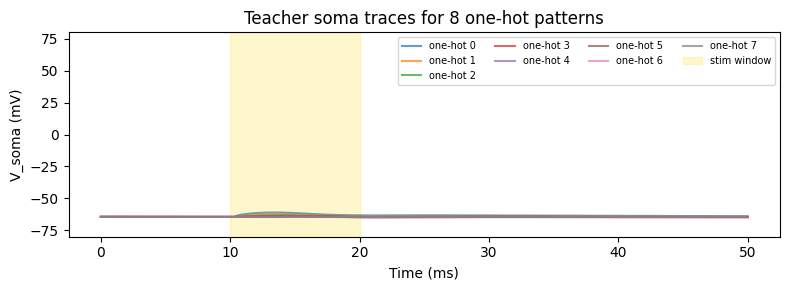

In [9]:
fig, ax = plt.subplots(figsize=(8, 3))
for p in range(Nsyn):
    ax.plot(t_arr, targets_onehot[p], alpha=0.7, label=f"one-hot {p}")
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.2, label="stim window")
ax.set_ylim(-80, 80)
ax.set_xlabel("Time (ms)"); ax.set_ylabel("V_soma (mV)")
ax.set_title("Teacher soma traces for 8 one-hot patterns")
ax.legend(fontsize=7, ncol=4)
plt.tight_layout(); plt.show()

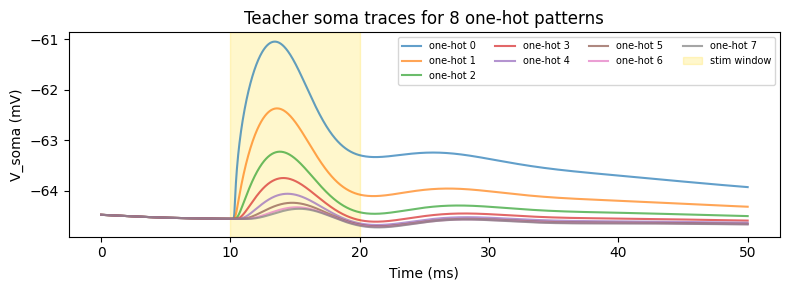

In [10]:
fig, ax = plt.subplots(figsize=(8, 3))
for p in range(Nsyn):
    ax.plot(t_arr, targets_onehot[p], alpha=0.7, label=f"one-hot {p}")
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.2, label="stim window")
ax.set_xlabel("Time (ms)"); ax.set_ylabel("V_soma (mV)")
ax.set_title("Teacher soma traces for 8 one-hot patterns")
ax.legend(fontsize=7, ncol=4)
plt.tight_layout(); plt.show()

### Gradient Check

In [ ]:
import jax
import jax.numpy as jnp


def loss_only(params_phys, pattern, target):
    # reuse your simulate_analysis
    soma_pred = simulate_analysis(params_phys, pattern)[0]  # (T,)
    return jnp.mean((soma_pred - target) ** 2)

loss_only_jit = jit(loss_only)

# --- batched loss over patterns ---
# patterns: (K, num_pre), targets: (K, T)
batched_loss_only = jit(vmap(loss_only, in_axes=(None, 0, 0)))
# gradient of loss_only wrt params_phys, per pattern
batched_vg_loss_only = jit(vmap(
    value_and_grad(loss_only, argnums=0),
    in_axes=(None, 0, 0),
))
# usage:
# losses, grads = batched_vg_loss_only(params_phys, patterns, targets)
# gS_grads = grads[0]["IonotropicSynapse_gS"]  # (K, Nsyn)

def one_hot_patterns(num_pre):
    return jnp.eye(num_pre, dtype=jnp.float32)

def make_check_patterns(num_pre, K, key):
    z = jnp.zeros((1, num_pre), dtype=jnp.float32)
    o = jnp.ones((1, num_pre), dtype=jnp.float32)
    oh = one_hot_patterns(num_pre)  # (num_pre, num_pre)

    base = jnp.concatenate([z, o, oh], axis=0)  # (2+num_pre, num_pre)

    # fill remaining slots with random Bernoulli patterns
    remaining = max(0, K - base.shape[0])
    if remaining > 0:
        rnd = jax.random.bernoulli(key, p=0.5, shape=(remaining, num_pre)).astype(jnp.float32)
        pats = jnp.concatenate([base, rnd], axis=0)
    else:
        pats = base[:K]
    return pats

def params_with_perturbed_synapse(params_phys, syn_idx: int, delta: float,
                                 gmin=1e-5, gmax=1e-2):
    gS = params_phys[0]["IonotropicSynapse_gS"]
    gS_new = jnp.clip(gS.at[syn_idx].add(delta), gmin, gmax)
    return [{"IonotropicSynapse_gS": gS_new}]

batched_loss_only = jax.jit(jax.vmap(loss_only, in_axes=(None, 0, 0)))  # returns (K,)

key = jax.random.PRNGKey(0)
K = 32  # good default on GPU
patterns_chk = make_check_patterns(num_pre=8, K=K, key=key)

# teacher targets only for checked patterns
targets_chk = batched_simulate_soma(params_true, patterns_chk)  # (K, T)


losses, grads = batched_vg_loss_only(params_analysis, patterns_chk, targets_chk)
gS_grads = grads[0]["IonotropicSynapse_gS"]  # (K, Nsyn)

def finite_diff_for_syn(syn_idx: int, eps: float):
    p_plus  = params_with_perturbed_synapse(params_analysis, syn_idx, +eps)
    p_minus = params_with_perturbed_synapse(params_analysis, syn_idx, -eps)
    Lp = batched_loss_only(p_plus,  patterns_chk, targets_chk)  # (K,)
    Lm = batched_loss_only(p_minus, patterns_chk, targets_chk)  # (K,)
    return (Lp - Lm) / (2.0 * eps)

# choose a few synapses (proximal/middle/distal indices by location)
syns_to_check = [0, Nsyn // 2, Nsyn - 1]

gS0 = params_analysis[0]["IonotropicSynapse_gS"]
for syn_idx in syns_to_check:
    # relative epsilon with a floor; avoids float32 cancellation
    eps = float(jnp.maximum(1e-4 * gS0[syn_idx], 1e-7))

    fd = finite_diff_for_syn(syn_idx, eps)       # (K,)
    ad = gS_grads[:, syn_idx]                    # (K,)

    denom = jnp.maximum(1e-12, jnp.maximum(jnp.abs(ad), jnp.abs(fd)))
    rel_err = jnp.abs(ad - fd) / denom
    sign_match = jnp.mean(jnp.sign(ad) == jnp.sign(fd))

    print(f"\nSynapse {syn_idx} | eps={eps:.2e}")
    print("  median rel_err:", float(jnp.median(rel_err)))
    print("  90% rel_err   :", float(jnp.quantile(rel_err, 0.90)))
    print("  max rel_err   :", float(jnp.max(rel_err)))
    print("  sign match %  :", float(sign_match))


Synapse 0 | eps=1.00e-07
  median rel_err: 2.644970939626363e-07
  90% rel_err   : 5.87498835542146e-06
  max rel_err   : 2.606522369347695e-05
  sign match %  : 1.0

Synapse 4 | eps=1.00e-07
  median rel_err: 1.0496723542409592e-07
  90% rel_err   : 8.317003685242968e-06
  max rel_err   : 8.010586914624485e-05
  sign match %  : 1.0

Synapse 7 | eps=1.00e-07
  median rel_err: 1.5052884015488208e-08
  90% rel_err   : 5.7509455605291e-06
  max rel_err   : 0.05233669062747779
  sign match %  : 1.0


In [15]:
syn_idx = 7

eps = 1e-7  # whatever you used
fd = finite_diff_for_syn(syn_idx, eps)     # (K,)
ad = gS_grads[:, syn_idx]                  # (K,)

denom = jnp.maximum(1e-12, jnp.maximum(jnp.abs(ad), jnp.abs(fd)))
rel_err = jnp.abs(ad - fd) / denom

k_star = int(jnp.argmax(rel_err))
print("worst pattern index:", k_star)
print("rel_err:", float(rel_err[k_star]))
print("ad:", float(ad[k_star]))
print("fd:", float(fd[k_star]))
print("abs error:", float(jnp.abs(ad[k_star] - fd[k_star])))
print("denom:", float(denom[k_star]))
print("pattern:", patterns_chk[k_star])

worst pattern index: 20
rel_err: 0.05233669062747779
ad: 1679.2351248000025
fd: 1771.9744008152823
abs error: 92.73927601527976
denom: 1771.9744008152823
pattern: [0. 0. 0. 1. 0. 1. 0. 1.]


In [18]:
import jax.numpy as jnp

def params_with_perturbed_synapse(params_phys, syn_idx: int, delta: float,
                                 gmin=1e-5, gmax=1e-2):
    gS = params_phys[0]["IonotropicSynapse_gS"]
    gS_new = jnp.clip(gS.at[syn_idx].add(delta), gmin, gmax)
    return [{"IonotropicSynapse_gS": gS_new}]

def finite_diff_grad_one(params_phys, pattern, target, syn_idx: int, eps: float):
    """
    Central difference estimate of dL/dgS[syn_idx] for ONE (pattern, target).
    """
    p_plus  = params_with_perturbed_synapse(params_phys, syn_idx, +eps)
    p_minus = params_with_perturbed_synapse(params_phys, syn_idx, -eps)

    Lp = loss_only_jit(p_plus,  pattern, target)
    Lm = loss_only_jit(p_minus, pattern, target)

    return (Lp - Lm) / (2.0 * eps)

syn_idx = 7
k_star = 20
pat = patterns_chk[k_star]
tgt = targets_chk[k_star]

ad = float(single_trial(params_analysis, pat, tgt)[0][syn_idx])
print("AD:", ad)

for eps in [1e-8, 3e-8, 1e-7, 3e-7, 1e-6, 3e-6]:
    fd = float(finite_diff_grad_one(params_analysis, pat, tgt, syn_idx, eps))
    rel = abs(ad - fd) / max(1e-12, abs(ad), abs(fd))
    print(f"eps={eps:.1e}  FD={fd:.6f}  rel_err={rel:.4f}")

AD: 1679.2351247269287
eps=1.0e-08  FD=1680.147343  rel_err=0.0005
eps=3.0e-08  FD=1687.455944  rel_err=0.0049
eps=1.0e-07  FD=1771.974401  rel_err=0.0523
eps=3.0e-07  FD=2645.437672  rel_err=0.3652
eps=1.0e-06  FD=125439103.428048  rel_err=1.0000
eps=3.0e-06  FD=40973573.378206  rel_err=1.0000


In [19]:
syn_idx = 7
g = float(params_analysis[0]["IonotropicSynapse_gS"][syn_idx])
for eps in [1e-8, 1e-7, 1e-6, 3e-6]:
    g_plus  = min(1e-2, max(1e-5, g + eps))
    g_minus = min(1e-2, max(1e-5, g - eps))
    print(eps, "g:", g, "g+:", g_plus, "g-:", g_minus, "clipped?", (g_plus != g+eps) or (g_minus != g-eps))

def loss_at_eps(eps):
    p_plus  = params_with_perturbed_synapse(params_analysis, syn_idx, +eps)
    p_minus = params_with_perturbed_synapse(params_analysis, syn_idx, -eps)
    Lp = float(loss_only_jit(p_plus,  pat, tgt))
    Lm = float(loss_only_jit(p_minus, pat, tgt))
    return Lp, Lm

for eps in [1e-8, 1e-7, 1e-6]:
    Lp, Lm = loss_at_eps(eps)
    print(eps, "Lp", Lp, "Lm", Lm, "diff", Lp-Lm)

1e-08 g: 9.624950507159263e-05 g+: 9.625950507159262e-05 g-: 9.623950507159263e-05 clipped? False
1e-07 g: 9.624950507159263e-05 g+: 9.634950507159263e-05 g-: 9.614950507159263e-05 clipped? False
1e-06 g: 9.624950507159263e-05 g+: 9.724950507159263e-05 g-: 9.524950507159263e-05 clipped? False
3e-06 g: 9.624950507159263e-05 g+: 9.924950507159263e-05 g-: 9.324950507159262e-05 clipped? False
1e-08 Lp 0.0004757546423053724 Lm 0.0004421516954550657 diff 3.360294685030669e-05
1e-07 Lp 0.0007062927991825424 Lm 0.0003518979190146786 diff 0.0003543948801678638
1e-06 Lp 250.87992444250935 Lm 0.0017175864143106777 diff 250.87820685609503


In [20]:
syn_idx = 7
eps = 1e-6  # the one that blew up
pat = patterns_chk[20]
tgt = targets_chk[20]

p_plus  = params_with_perturbed_synapse(params_analysis, syn_idx, +eps)
p_minus = params_with_perturbed_synapse(params_analysis, syn_idx, -eps)

v_plus  = simulate_soma(p_plus,  pat)
v_minus = simulate_soma(p_minus, pat)

def summarize(v, name):
    v = jnp.asarray(v)
    print(name,
          "min", float(jnp.min(v)),
          "max", float(jnp.max(v)),
          "has_nan", bool(jnp.any(jnp.isnan(v))),
          "has_inf", bool(jnp.any(jnp.isinf(v))))

summarize(v_plus,  "v_plus")
summarize(v_minus, "v_minus")

# crude spike timing (adjust threshold if needed)
thr = 0.0
def first_cross(v):
    hits = jnp.where(v > thr, size=v.shape[0], fill_value=-1)[0]
    # hits[0] is first index where v>thr, or -1 if never crosses
    return int(hits[0])

print("first_cross plus/minus:", first_cross(v_plus), first_cross(v_minus),
      "delta_t(ms) =", (first_cross(v_plus)-first_cross(v_minus))*dt)

v_plus min -76.084199767913 max 39.644424816007486 has_nan False has_inf False
v_minus min -65.52971841388533 max -62.800494754896846 has_nan False has_inf False
first_cross plus/minus: 810 -1 delta_t(ms) = 20.275000000000002


syn_idx = 7
g = float(params_analysis[0]["IonotropicSynapse_gS"][syn_idx])
for eps in [1e-8, 1e-7, 1e-6, 3e-6]:
    g_plus  = min(1e-2, max(1e-5, g + eps))
    g_minus = min(1e-2, max(1e-5, g - eps))
    print(eps, "g:", g, "g+:", g_plus, "g-:", g_minus, "clipped?", (g_plus != g+eps) or (g_minus != g-eps))

def loss_at_eps(eps):
    p_plus  = params_with_perturbed_synapse(params_analysis, syn_idx, +eps)
    p_minus = params_with_perturbed_synapse(params_analysis, syn_idx, -eps)
    Lp = float(loss_only_jit(p_plus,  pat, tgt))
    Lm = float(loss_only_jit(p_minus, pat, tgt))
    return Lp, Lm

for eps in [1e-8, 1e-7, 1e-6]:
    Lp, Lm = loss_at_eps(eps)
    print(eps, "Lp", Lp, "Lm", Lm, "diff", Lp-Lm)

In [ ]:
def _rising_edges(mask: jnp.ndarray) -> jnp.ndarray:
    """Boolean array marking rising edges of a boolean mask."""
    # mask: (T,)
    return jnp.logical_and(mask[1:], jnp.logical_not(mask[:-1]))  # (T-1,)

def _first_true_idx(mask: jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Return (idx, has_any) where idx is first True index, -1 if none."""
    has = jnp.any(mask)
    idx = jnp.argmax(mask)                # 0 if none, so guard with has
    idx = jnp.where(has, idx, -1)
    return idx, has

def detect_spike_like_event(
    v: jnp.ndarray,
    dt: float,
    v_th: float,
    dvdt_th: float,
) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """
    Detects a spike-like event in a single trace v(t).
    Event happens if:
      - v crosses upward over v_th  OR
      - dV/dt crosses upward over dvdt_th

    Returns:
      has_event: bool
      first_idx: int (sample index in v), -1 if none
      n_events:  int (count of detected events; rough)
    """
    # 1) Voltage threshold crossing (upcrossings)
    above_v = v >= v_th
    v_cross = _rising_edges(above_v)            # (T-1,)
    v_first, has_v = _first_true_idx(v_cross)   # index into v_cross
    v_first = jnp.where(has_v, v_first + 1, -1) # map to v index
    n_v = jnp.sum(v_cross).astype(jnp.int32)

    # 2) dV/dt threshold crossing (fast upstroke)
    dvdt = jnp.diff(v) / dt                     # (T-1,) in mV/ms if v in mV and dt in ms
    above_d = dvdt >= dvdt_th
    d_cross = _rising_edges(above_d)            # (T-2,)
    d_first, has_d = _first_true_idx(d_cross)   # index into d_cross
    d_first = jnp.where(has_d, d_first + 2, -1) # +2 to map to v index
    n_d = jnp.sum(d_cross).astype(jnp.int32)

    has_event = jnp.logical_or(has_v, has_d)

    big = jnp.int32(v.shape[0] + 1)
    v_idx = jnp.where(has_v, v_first.astype(jnp.int32), big)
    d_idx = jnp.where(has_d, d_first.astype(jnp.int32), big)
    first_idx = jnp.minimum(v_idx, d_idx)
    first_idx = jnp.where(has_event, first_idx, -1)

    n_events = (n_v + n_d).astype(jnp.int32)
    return has_event, first_idx.astype(jnp.int32), n_events

# JIT + VMAP helpers
detect_spike_like_event_jit = jit(detect_spike_like_event)

# Batch over compartments: traces shape (C, T)
batched_detect = jit(vmap(detect_spike_like_event, in_axes=(0, None, None, None)))

def analyze_trial_events(
    raw_traces: jnp.ndarray,  # (n_recordings, T)
    dt: float,
    soma_v_th: float = 0.0,
    soma_dvdt_th: float = 30.0,
    dend_v_th: float = -20.0,
    dend_dvdt_th: float = 10.0,
):
    soma_v = raw_traces[0]
    dend_v = raw_traces[1:]  # (n_dend, T)

    # Somatic AP
    soma_has, soma_t0, soma_n = detect_spike_like_event_jit(
        soma_v, dt, soma_v_th, soma_dvdt_th
    )

    # Dendritic spike-like events (per recorded dend trace)
    dend_has, dend_t0, dend_n = batched_detect(
        dend_v, dt, dend_v_th, dend_dvdt_th
    )  # each: (n_dend,)

    dend_any = jnp.any(dend_has)

    # If soma spikes, check whether any dendritic event occurs BEFORE soma event
    # (simple heuristic for dendritic-led vs bAP-driven events)
    soma_t0_safe = jnp.where(soma_has, soma_t0, jnp.int32(raw_traces.shape[1] + 1))
    dend_leads_soma = jnp.logical_and(dend_has, dend_t0 < soma_t0_safe)  # (n_dend,)
    any_dend_leads = jnp.any(dend_leads_soma)

    # Dend spikes without soma spike:
    dend_without_soma = jnp.logical_and(dend_any, jnp.logical_not(soma_has))

    return {
        "soma_has_ap": soma_has,
        "soma_t0_idx": soma_t0,
        "dend_any": dend_any,
        "dend_has": dend_has,
        "dend_t0_idx": dend_t0,
        "any_dend_leads_soma": any_dend_leads,
        "dend_without_soma": dend_without_soma,
    }

# one pattern
raw_traces = simulate_analysis(params_true, patterns_onehot[0])  # (n_recordings, T_keep)
stats = analyze_trial_events(raw_traces, dt)
print(stats["soma_has_ap"], stats["dend_without_soma"], stats["any_dend_leads_soma"])

### Optional hyperparameter tuning: minimal synaptic weight and pattern to create somatic action potential

In [16]:
def has_somatic_ap(v_soma: jnp.ndarray, dt: float,
                   v_overshoot_th: float = 0.0,
                   dvdt_th: float = 30.0,
                   v_floor_for_dvdt: float = -20.0) -> jnp.bool_:
    # condition A: overshoot
    overshoot = jnp.any(v_soma >= v_overshoot_th)

    # condition B: fast upstroke + sufficiently depolarized
    dvdt = jnp.diff(v_soma) / dt  # mV/ms
    fast_up = jnp.any((dvdt >= dvdt_th) & (v_soma[1:] >= v_floor_for_dvdt))

    return overshoot | fast_up

batched_has_somatic_ap = jit(vmap(has_somatic_ap, in_axes=(0, None, None, None, None)))

In [14]:
# pattern_all_on  = jnp.ones((Nsyn,), dtype=jnp.float32)

# def patterns_of_weight(k: int) -> jnp.ndarray:
#     from itertools import combinations
#     idxs = []
#     for comb in combinations(range(Nsyn), k):
#         p = np.zeros((Nsyn,), dtype=np.float32)
#         p[list(comb)] = 1.0
#         idxs.append(p)
#     return jnp.asarray(np.stack(idxs, axis=0))

# # identify which synapse is on soma (comp 0)
# soma_syn_mask = (syn_post_comp_indices == 0)
# # if multiple happen to be 0 (unlikely), this still works.
# soma_onehot_indices = np.where(soma_syn_mask)[0].tolist()

# def eval_gS(gS_value: float):
#     # set ALL synapses to this gS (same as you do)
#     net_analysis.IonotropicSynapse.set("IonotropicSynapse_gS", float(gS_value))

#     params = net_analysis.get_parameters()
#     gS_vec = params[0]["IonotropicSynapse_gS"]
#     params_phys = [{"IonotropicSynapse_gS": gS_vec}]

#     # all-on
#     v_all = simulate_soma(params_phys, pattern_all_on)
#     all_on_ap = bool(has_somatic_ap(v_all, dt))

#     # onehots
#     v_1 = batched_simulate_soma(params_phys, patterns_onehot)  # (8,T)
#     onehot_ap = batched_has_somatic_ap(v_1, dt, 0.0, 30.0, -20.0)  # (8,)
#     onehot_ap = jnp.asarray(onehot_ap)

#     n_onehot = int(jnp.sum(onehot_ap))
#     any_onehot = bool(jnp.any(onehot_ap))

#     # minimal k
#     min_k = None
#     for k in range(1, Nsyn + 1):
#         Pk = patterns_of_weight(k)
#         v_k = batched_simulate_soma(params_phys, Pk)
#         ap_k = batched_has_somatic_ap(v_k, dt, 0.0, 30.0, -20.0)
#         if bool(jnp.any(ap_k)):
#             min_k = k
#             break

#     return {
#         "gS": float(gS_value),
#         "all_on_ap": all_on_ap,
#         "onehot_ap": onehot_ap,   # boolean (8,)
#         "n_onehot_ap": n_onehot,
#         "min_k": min_k,
#     }

# # run sweep
# gS_sweep = np.geomspace(1e-4, 5e-4, 9)
# results = [eval_gS(g) for g in gS_sweep]

# for r in results:
#     print(f"gS={r['gS']:.2e} | all-on AP={r['all_on_ap']} | "
#           f"onehot AP={r['n_onehot_ap']}/8 | min_k={r['min_k']}")

# # pick rule A: strict (no onehot AP at all)
# picked_strict = None
# for r in results:
#     if r["all_on_ap"] and (r["n_onehot_ap"] == 0) and (r["min_k"] is not None) and (2 <= r["min_k"] <= 5):
#         picked_strict = r
#         break

# # pick rule B: allow soma-onehot AP only
# picked_allow_soma = None
# for r in results:
#     oh = np.array(r["onehot_ap"], dtype=bool)
#     ok = True
#     for i in range(Nsyn):
#         if oh[i] and (i not in soma_onehot_indices):  # any non-soma onehot AP -> reject
#             ok = False
#             break
#     if r["all_on_ap"] and ok and (r["min_k"] is not None) and (2 <= r["min_k"] <= 5):
#         picked_allow_soma = r
#         break

# print("\nPicked (strict):", None if picked_strict is None else picked_strict["gS"])
# print("Picked (allow soma onehot):", None if picked_allow_soma is None else picked_allow_soma["gS"])

patterns_3hot shape: (56, 8)
targets_3hot shape: (56, 2001)
# somatic APs in 3-hot set: 16 / 56


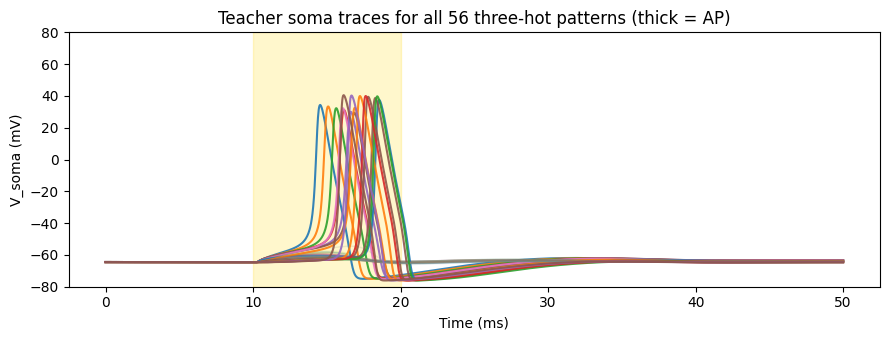

Spiking 3-hot pattern indices: [ 0  1  2  3  4  5  6 20 21 35 45 51 52 53 54 55]
pattern 0: on synapses [0 1 2]
pattern 1: on synapses [0 1 3]
pattern 2: on synapses [0 1 4]
pattern 3: on synapses [0 1 5]
pattern 4: on synapses [0 1 6]
pattern 5: on synapses [0 1 7]
pattern 6: on synapses [0 2 3]
pattern 20: on synapses [0 6 7]
pattern 21: on synapses [1 2 3]
pattern 35: on synapses [1 6 7]
pattern 45: on synapses [2 6 7]
pattern 51: on synapses [3 6 7]
pattern 52: on synapses [4 5 6]
pattern 53: on synapses [4 5 7]
pattern 54: on synapses [4 6 7]
pattern 55: on synapses [5 6 7]


In [17]:
def patterns_of_weight_k(N, k, dtype=np.float64):
    pats = []
    from itertools import combinations
    for comb in combinations(range(N), k):
        p = np.zeros((N,), dtype=dtype)
        p[list(comb)] = 1.0
        pats.append(p)
    return jnp.asarray(np.stack(pats, axis=0))

patterns_3hot = patterns_of_weight_k(Nsyn, 3)   # (56, 8)
print("patterns_3hot shape:", patterns_3hot.shape)

# ---- simulate soma for all 3-hot patterns
targets_3hot = batched_simulate_soma(params_true, patterns_3hot)  # (56, T)
T = targets_3hot.shape[1]
t_arr = np.arange(T_keep) * dt

print("targets_3hot shape:", targets_3hot.shape)

# ---- (optional) compute which 3-hot patterns cause somatic AP (using your AP detector)
ap_3hot = jnp.array([has_somatic_ap(targets_3hot[i], dt) for i in range(targets_3hot.shape[0])])
print(f"# somatic APs in 3-hot set: {int(ap_3hot.sum())} / {targets_3hot.shape[0]}")

# ---- plot: overlay all traces (AP ones thicker)
fig, ax = plt.subplots(figsize=(9, 3.5))

for i in range(targets_3hot.shape[0]):
    if bool(ap_3hot[i]):
        ax.plot(t_arr, np.array(targets_3hot[i]), alpha=0.9, lw=1.5)
    else:
        ax.plot(t_arr, np.array(targets_3hot[i]), alpha=0.15, lw=1.0)

ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.2, label="stim window")
ax.set_ylim(-80, 80)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("V_soma (mV)")
ax.set_title("Teacher soma traces for all 56 three-hot patterns (thick = AP)")
plt.tight_layout()
plt.show()

# ---- (optional) show which 3-hot patterns spiked (by indices)
spiking_idx = np.where(np.array(ap_3hot, dtype=bool))[0]
print("Spiking 3-hot pattern indices:", spiking_idx)

# print the actual active synapse indices for each spiking pattern
for i in spiking_idx[:]:  # show first 10
    on = np.where(np.array(patterns_3hot[i]) > 0.5)[0]
    print(f"pattern {i}: on synapses {on}")

In [ ]:
# # syn_post_comp_indices tells you where synapse i lands
# spiking_patterns = spiking_idx 
# P = np.array(patterns_3hot)
# comp = np.array(syn_post_comp_indices)

# # average landing position for each 3-hot pattern
# avg_comp = (P @ comp) / 3.0

# print("mean avg_comp among all patterns:", avg_comp.mean())
# print("mean avg_comp among spiking patterns:", avg_comp[spiking_patterns].mean())

mean avg_comp among all patterns: 7.0
mean avg_comp among spiking patterns: 7.0


### Infrastructure to detect dendritic events (use in correlations)

In [ ]:
def detect_event_per_trace(v: jnp.ndarray, dt: float,
                           v_th: float = -20.0,
                           dvdt_th: float = 10.0) -> jnp.bool_:
    above_v = jnp.any(v >= v_th)
    dvdt = jnp.diff(v) / dt
    fast = jnp.any(dvdt >= dvdt_th)
    return above_v | fast

batched_detect_event = jit(vmap(detect_event_per_trace, in_axes=(0, None, None, None)))

def dendritic_events(raw_traces_post: jnp.ndarray, dt: float):
    # raw_traces_post: (n_post_comp, T), comp 0 is soma
    soma_v = raw_traces_post[0]
    dend_v = raw_traces_post[1:]

    soma_ap = has_somatic_ap(soma_v, dt)
    dend_evt = batched_detect_event(dend_v, dt, -20.0, 10.0)  # (n_post_comp-1,)
    dend_any = jnp.any(dend_evt)

    dend_without_soma = dend_any & (~soma_ap)
    return soma_ap, dend_evt, dend_without_soma

### Gradient Factorization

Because loss is:
```
L = mean_t (V_soma(t) - target(t))^2
```

the "credit/adjoint" term is analytic:

$$\frac{\partial L}{\partial V_{\text{soma}}(t)} = \frac{2}{T}\,(V_{\text{soma}}(t) - \text{target}(t))$$

We have:
1. autograd gradient `dL/dg` (what you already do)
2. Jacobian $J(t,i) = \partial V(t) / \partial g_i$
3. factorized gradient $J^\top \cdot (dL/dV)$
4. verify they match

In [18]:
pattern = patterns_onehot[0]

# teacher target
target = batched_simulate_soma(params_true, pattern[None, :])[0]

# student params (perturbed)
gS_student = params_analysis[0]["IonotropicSynapse_gS"]

params_student = [{"IonotropicSynapse_gS": gS_student}]

grad_w, raw_traces, loss = single_trial(params_student, pattern, target)

v = raw_traces[0]
T = v.shape[0]
dL_dV = (2.0 / T) * (v - target)

def soma_from_gS(gS_vec, pattern):
    params_phys = [{"IonotropicSynapse_gS": gS_vec}]
    return simulate_soma(params_phys, pattern)   # (T_keep,)

# 2) Jacobian: dV_soma(t)/dgS_i
J_soma_wrt_gS = jit(jax.jacfwd(soma_from_gS, argnums=0))
# returns shape (T_keep, Nsyn)

J = J_soma_wrt_gS(gS_student, pattern)   # (T, Nsyn)
grad_fact = J.T @ dL_dV                  # (Nsyn,)

max_abs = jnp.max(jnp.abs(grad_w - grad_fact))
rel = max_abs / (jnp.max(jnp.abs(grad_w)) + 1e-12)

print("loss:", float(loss))
print("grad_w:", grad_w)
print("grad_fact:", grad_fact)
print("max |diff|:", float(max_abs))
print("rel:", float(rel))

loss: 0.007718069218677725
grad_w: [-2.69184291e+03 -1.07301620e+02 -5.21085721e+01 -2.55214582e+01
 -1.26293885e+01 -6.41332089e+00 -3.55899648e+00 -2.55471775e+00]
grad_fact: [-2.69184291e+03 -1.07301620e+02 -5.21085721e+01 -2.55214582e+01
 -1.26293885e+01 -6.41332089e+00 -3.55899648e+00 -2.55471775e+00]
max |diff|: 1.6825651982799172e-11
rel: 6.250606949435678e-15


In [19]:
J_soma_wrt_gS = jit(jax.jacfwd(soma_from_gS, argnums=0))  # (T, Nsyn)

# batch over patterns: returns (P, T, Nsyn)
batched_J = jit(jax.vmap(lambda pat, gS: J_soma_wrt_gS(gS, pat),
                         in_axes=(0, None)))

Analysis

In [ ]:
# def make_batched_vg_for_net(net_obj):
#     def simulate_analysis_net(params_phys, pattern):
#         amps = base_amp * pattern
#         currents = jx.datapoint_to_step_currents(
#             i_delay=i_delay_eff, i_dur=i_dur,
#             i_amp=amps, delta_t=dt, t_max=t_max_eff,
#         )
#         net_obj.delete_stimuli()
#         data_stimuli = None
#         for i in range(num_pre):
#             data_stimuli = (
#                 net_obj.cell(i).branch(0).loc(0.0)
#                 .data_stimulate(currents[i], data_stimuli=data_stimuli)
#             )
#         traces = jx.integrate(net_obj, params=params_phys,
#                               data_stimuli=data_stimuli, delta_t=dt)
#         return traces[:, i0:i0 + T_keep]   # (n_sites, T_keep)

#     def loss_and_traces_net(params_phys, pattern, target):
#         raw_traces = simulate_analysis_net(params_phys, pattern)
#         soma_pred = raw_traces[0]
#         loss = jnp.mean((soma_pred - target) ** 2)
#         return loss, raw_traces

#     batched_vg_net = jit(jax.vmap(
#         jax.value_and_grad(loss_and_traces_net, argnums=0, has_aux=True),
#         in_axes=(None, 0, 0),
#     ))
#     return simulate_analysis_net, batched_vg_net

In [20]:
# probe patterns
patterns_probe = patterns_3hot            # (56, 8)
P = patterns_probe.shape[0]

# teacher targets for those probes
batched_simulate_soma_probe = jit(vmap(simulate_soma, in_axes=(None, 0)))
targets_probe = batched_simulate_soma_probe(params_true, patterns_probe)  # (56, T_keep)

In [21]:
net_train = build_net()
net_train.delete_recordings()
net_train.cell(post_idx).branch(0).comp(0).record() # soma only
for ci in syn_post_comp_indices:
    if int(ci) != 0:
        net_train.cell(post_idx).branch(0).comp(int(ci)).record() # all synapses except soma
net_train.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")

train_transform = jx.ParamTransform([
    {"IonotropicSynapse_gS": jt.SigmoidTransform(1e-5, 1e-2)},
])

def _sim_soma_train(params_phys, pattern):
    amps = base_amp * pattern
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay_eff, i_dur=i_dur, i_amp=amps, delta_t=dt, t_max=t_max_eff,
    )
    net_train.delete_stimuli()
    data_stimuli = None
    for i in range(num_pre):
        data_stimuli = (
            net_train.cell(i).branch(0).loc(0.0)
            .data_stimulate(currents[i], data_stimuli=data_stimuli)
        )
    traces = jx.integrate(
        net_train, params=params_phys,
        data_stimuli=data_stimuli, delta_t=dt,
    )
    # crop out warmup to return clean 0...50ms window
    return traces[0, i0:i0 + T_keep] # (T,)

_batched_soma_train = vmap(_sim_soma_train, in_axes=(None, 0))

def _train_loss_batch(opt_params, pats, tgts):
    params_phys = train_transform.forward(opt_params)
    preds = _batched_soma_train(params_phys, pats)            # (B, T)
    return jnp.mean((preds - tgts) ** 2)

train_lr = 0.05
train_optimizer = optax.adam(train_lr)

@jit
def _train_step(opt_params, opt_state, pats, tgts):
    loss, grads = jax.value_and_grad(_train_loss_batch)(
        opt_params, pats, tgts,
    )
    updates, new_state = train_optimizer.update(grads, opt_state, opt_params)
    new_params = optax.apply_updates(opt_params, updates)
    return new_params, new_state, loss

checkpoints = [10, 25, 50]
n_steps_train = max(checkpoints)  

def train_one_seed(seed, patterns_train, targets_train,
                   n_steps=50, checkpoints=(10, 25, 50), log_every=5):
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)
    gS0 = jnp.clip(
        1e-4 * jnp.exp(0.15 * jax.random.normal(subkey, (Nsyn,))),
        1e-5, 1e-2,
    )
    params0 = [{"IonotropicSynapse_gS": gS0}]
    opt_params = train_transform.inverse(params0)
    opt_state = train_optimizer.init(opt_params)

    loss_log = []
    checkpoint_params = {}   
    ckpt_set = set(checkpoints)

    for step in range(1, n_steps + 1):
        opt_params, opt_state, loss = _train_step(
            opt_params, opt_state, patterns_train, targets_train,
        )

        if step % log_every == 0 or step == n_steps:
            loss_log.append((step, float(loss)))

        if step in ckpt_set:
            checkpoint_params[step] = train_transform.forward(opt_params)

    return checkpoint_params, {"losses": loss_log, "final_loss": float(loss)}


print(f"Sanity check: training seed=0 ({n_steps_train} steps, "
      f"checkpoints at {checkpoints})")
t0 = time.time()
ckpt0, log0 = train_one_seed(0, patterns_probe, targets_probe)
t1 = time.time()
print(f"Time: {t1-t0:.1f}s")
print(f"Init loss: {log0['losses'][0][1]:.4f}")
print(f"Final loss:{log0['final_loss']:.4f}")
for c in sorted(ckpt0):
    gS_c = np.asarray(ckpt0[c][0]["IonotropicSynapse_gS"])
    print(f"gS @ step {c:3d}: {gS_c}  "
          f"(max |diff| from true = {np.abs(gS_c - np.asarray(gS_true)).max():.2e})")


Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Number of newly added trainable parameters: 8. Total number of trainable parameters: 8
Sanity check: training seed=0 (50 steps, checkpoints at [10, 25, 50])
Time: 77.0s
Init loss: 38.4022
Final loss:3.5936
gS @ step  10: [8.16253102e-05 1.20238140e-04 1.11267699e-04 1.05553878e-04
 9.90042634e-05 1.04258519e-04 9.79894589e-05 1.07137379e-04]  (max |diff| from true = 2.02e-05)
gS @ step  25: [8.95243732e-05 1.13337436e-04 1.06573864e-04 1.01773966e-04
 9.85189046e-05 1.03642267e-04 9.58028841e-05 1.03503060e-04]  (max |diff| from true = 1.33e-05)
gS @ step  50: [1.03642920e-04 9.5710147

In [22]:
# 1) Edges: do they match exactly (pre/post + post_comp location)?
cols = ["pre_index", "post_index", "post_locs", "type", "type_ind", "IonotropicSynapse_gS"]
print(net_analysis.edges[cols].reset_index(drop=True).head(10))
print(net_train.edges[cols].reset_index(drop=True).head(10))

same_edges = net_analysis.edges[cols].reset_index(drop=True).equals(
    net_train.edges[cols].reset_index(drop=True)
)
print("same edge table:", same_edges)

# 2) Recordings: do they match?
print("analysis recordings:", net_analysis.recordings)
print("train recordings:", net_train.recordings)
print("same recordings:", net_analysis.recordings == net_train.recordings)

   pre_index  post_index  post_locs               type  type_ind  \
0          0           8   0.033333  IonotropicSynapse         0   
1          1          10   0.166667  IonotropicSynapse         0   
2          2          12   0.300000  IonotropicSynapse         0   
3          3          14   0.433333  IonotropicSynapse         0   
4          4          16   0.566667  IonotropicSynapse         0   
5          5          18   0.700000  IonotropicSynapse         0   
6          6          20   0.833333  IonotropicSynapse         0   
7          7          22   0.966667  IonotropicSynapse         0   

   IonotropicSynapse_gS  
0                0.0001  
1                0.0001  
2                0.0001  
3                0.0001  
4                0.0001  
5                0.0001  
6                0.0001  
7                0.0001  
   pre_index  post_index  post_locs               type  type_ind  \
0          0           8   0.033333  IonotropicSynapse         0   
1          1     

In [23]:
S = 30

n_sites = 1 + np.sum(np.array(syn_post_comp_indices) != 0)  # soma + nonzero syn comps
# with your setup, n_sites should be 8

VALL_ckpt  = {c: np.zeros((S, P, n_sites, T_keep), dtype=np.float32) for c in checkpoints}
GRADS_ckpt = {c: np.zeros((S, P, Nsyn),          dtype=np.float32) for c in checkpoints}
LOSS_ckpt  = {c: np.zeros((S, P),                dtype=np.float32) for c in checkpoints}
gS_ckpt    = {c: np.zeros((S, Nsyn),             dtype=np.float32) for c in checkpoints}
JALL_ckpt  = {c: np.zeros((S, P, T_keep, Nsyn),  dtype=np.float32) for c in checkpoints}

train_logs_all = []

print(f"Training {S} seeds × {n_steps_train} steps ")
print(f"Checkpoints: {checkpoints}")
print(f"Per-checkpoint shapes:  GRADS (S,8,8)  VALL (S,8,8,{T_keep})  LOSS (S,8)\n")

t_start = time.time()

for s in range(S):
    t_seed = time.time()

    ckpt_params_s, log_s = train_one_seed(
        seed=s, patterns_train=patterns_probe, targets_train=targets_probe
    )
    train_logs_all.append(log_s)

    for c in checkpoints:
        params_c = ckpt_params_s[c]
        gS_vec = params_c[0]["IonotropicSynapse_gS"]  # (Nsyn,)
        gS_ckpt[c][s] = np.asarray(gS_vec, dtype=np.float32)       # (Nsyn,)

        # Basics: loss, traces, grads on the 8 one-hot probes
        ((losses_c, traces_c), grads_c) = batched_vg(params_c, patterns_probe, targets_probe)

        VALL_ckpt[c][s]  = np.asarray(traces_c, dtype=np.float32)  # (P, n_sites, T_keep)
        GRADS_ckpt[c][s] = np.asarray(grads_c[0]["IonotropicSynapse_gS"], dtype=np.float32)  # (P, Nsyn)
        LOSS_ckpt[c][s]  = np.asarray(losses_c, dtype=np.float32)  # (P,)

        Jp = batched_J(patterns_probe, gS_vec)                     # (P, T_keep, Nsyn)
        JALL_ckpt[c][s] = np.asarray(Jp, dtype=np.float32)

    dt_seed = time.time() - t_seed
    if s % 5 == 0 or s == S - 1:
        losses_str = "  ".join(
            f"step{c}={float(LOSS_ckpt[c][s].mean()):.4f}"
            for c in checkpoints
        )
        print(f"  seed {s:3d}/{S}  {losses_str}  ({dt_seed:.1f}s)")

elapsed = time.time() - t_start
print(f"\nDone: {S} seeds in {elapsed:.1f}s  ({elapsed / S:.1f}s per seed)")
print(f"Train final-loss range: "
      f"[{min(l['final_loss'] for l in train_logs_all):.4f}, "
      f"{max(l['final_loss'] for l in train_logs_all):.4f}]")

print(f"\nPer-checkpoint probe loss (mean across seeds & patterns):")
for c in checkpoints:
    print(f"  step {c:3d}:  mean loss = {LOSS_ckpt[c].mean():.6f}  "
          f"  gS spread (std) = {gS_ckpt[c].std(axis=0).mean():.2e}")

Training 30 seeds × 50 steps 
Checkpoints: [10, 25, 50]
Per-checkpoint shapes:  GRADS (S,8,8)  VALL (S,8,8,2001)  LOSS (S,8)



  seed   0/30  step10=30.8022  step25=13.7436  step50=3.5636  (88.7s)
  seed   5/30  step10=2.3132  step25=3.7775  step50=2.9940  (75.0s)
  seed  10/30  step10=13.4131  step25=7.4918  step50=4.5863  (75.0s)
  seed  15/30  step10=13.9690  step25=19.5030  step50=20.9436  (75.0s)
  seed  20/30  step10=28.0587  step25=13.0748  step50=3.4474  (75.1s)
  seed  25/30  step10=7.5924  step25=3.7036  step50=2.9791  (75.1s)
  seed  29/30  step10=55.5547  step25=26.5124  step50=12.1574  (75.0s)

Done: 30 seeds in 2265.0s  (75.5s per seed)
Train final-loss range: [3.0108, 17.2280]

Per-checkpoint probe loss (mean across seeds & patterns):
  step  10:  mean loss = 19.703478    gS spread (std) = 9.49e-06
  step  25:  mean loss = 9.980962    gS spread (std) = 6.73e-06
  step  50:  mean loss = 6.397572    gS spread (std) = 4.93e-06


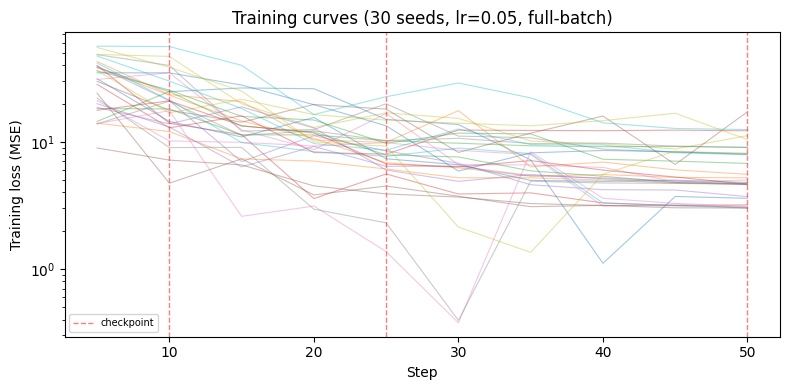

In [25]:
# training loss curves
fig, ax = plt.subplots(figsize=(8, 4))

for s_i, log_s in enumerate(train_logs_all):
    if len(log_s["losses"]) == 0:
        continue
    steps, losses = zip(*log_s["losses"])
    ax.plot(steps, losses, alpha=0.4, lw=0.8)

# checkpoint lines (label only once)
for i, c in enumerate(checkpoints):
    ax.axvline(c, color="red", ls="--", lw=1, alpha=0.5,
               label="checkpoint" if i == 0 else None)

ax.set_xlabel("Step")
ax.set_ylabel("Training loss (MSE)")
ax.set_title(f"Training curves ({S} seeds, lr={train_lr}, full-batch)")
ax.set_yscale("log")

ax.legend(fontsize=7)
plt.tight_layout()
plt.show()

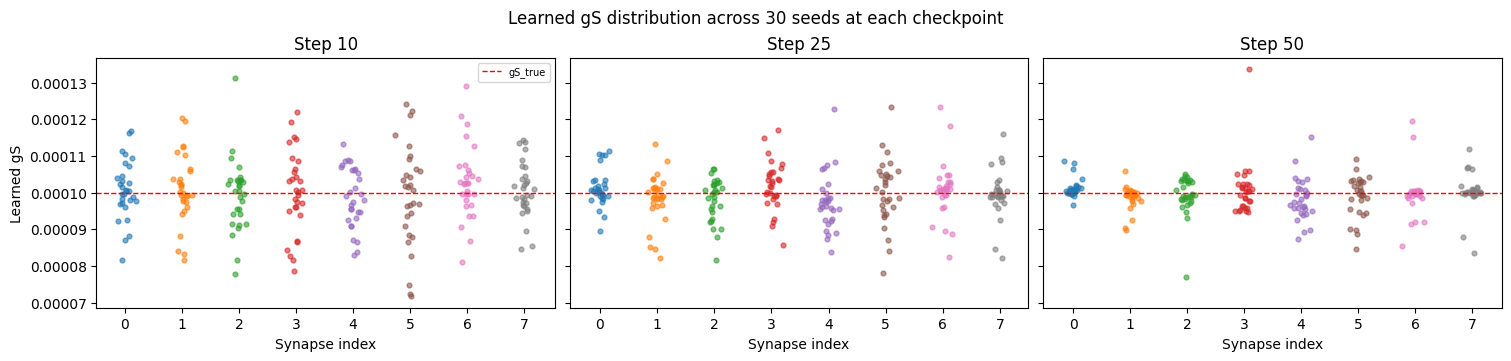

In [26]:
# learned gS at each checkpoint 
n_ckpt = len(checkpoints)
fig, axes = plt.subplots(1, n_ckpt, figsize=(5 * n_ckpt, 3.5),
                         sharey=True, constrained_layout=True)

if n_ckpt == 1:
    axes = [axes]

for ci, c in enumerate(checkpoints):
    ax = axes[ci]
    for i in range(Nsyn):
        ax.scatter(
            np.full(S, i) + 0.08 * np.random.randn(S),
            gS_ckpt[c][:, i],
            s=12, alpha=0.6
        )

    ax.axhline(float(gS_true[0]), color="red", ls="--", lw=1,
               label="gS_true" if ci == 0 else None)

    ax.set_xlabel("Synapse index")
    if ci == 0:
        ax.set_ylabel("Learned gS")
    ax.set_title(f"Step {c}")

    if ci == 0:
        ax.legend(fontsize=7)

fig.suptitle(f"Learned gS distribution across {S} seeds at each checkpoint", fontsize=12)
plt.show()

In [27]:
def corr_over_seeds(X, y, eps=1e-12):
    # X: (S, T_keep), y: (S,)
    Xc = X - X.mean(axis=0, keepdims=True)
    yc = y - y.mean()
    num = (Xc * yc[:, None]).sum(axis=0)
    den = np.sqrt((Xc**2).sum(axis=0) * (yc**2).sum() + eps)
    return num / den

R_ckpt = {}        # {c: (P, i, j, t)} = (8,8,8,T_keep)
r_diag_ckpt = {}   # {c: (8, T_keep)} = R[p,p,p,t]
r_off_ckpt  = {}   # {c: (8, 8, T_keep)} = R[p,p,j,t]
R_grad_ckpt = {}   # optional: {c: (8,8,T_keep)} = soma-only correlations

for c in checkpoints:
    Vraw = VALL_ckpt[c]   # (S, 8, 8, T_keep)
    G    = GRADS_ckpt[c]  # (S, 8, 8)

    R = np.zeros((Nsyn, Nsyn, Nsyn, T_keep), dtype=np.float32)

    for p in range(Nsyn):
        for i in range(Nsyn):
            g_pi = G[:, p, i]  # (S,)
            for j in range(Nsyn):
                R[p, i, j, :] = corr_over_seeds(Vraw[:, p, j, :], g_pi).astype(np.float32)

    R_ckpt[c] = R
    r_diag_ckpt[c] = R[np.arange(Nsyn), np.arange(Nsyn), np.arange(Nsyn), :]   # (8, T_keep)
    r_off_ckpt[c]  = R[np.arange(Nsyn), np.arange(Nsyn), :, :]                 # (8, 8, T_keep)

    # soma-only (optional)
    R_grad_ckpt[c] = R[:, :, 0, :]  # (8,8,T_keep)

In [28]:
print(R_ckpt[checkpoints[0]].shape)   # should be (8,8,8,T_keep)
print(r_diag_ckpt[checkpoints[0]].shape)  # (8,T_keep)
print(R_grad_ckpt[checkpoints[0]].shape)  # (8,8,T_keep)

(8, 8, 8, 2001)
(8, 2001)
(8, 8, 2001)


In [29]:
def corr_pair_over_seeds(X, Y, eps=1e-12):
    # X, Y: (S, T_keep)
    Xc = X - X.mean(axis=0, keepdims=True)
    Yc = Y - Y.mean(axis=0, keepdims=True)
    num = (Xc * Yc).sum(axis=0)
    den = np.sqrt((Xc**2).sum(axis=0) * (Yc**2).sum(axis=0) + eps)
    return num / den

R_J_ckpt = {}

for c in checkpoints:
    Vraw = VALL_ckpt[c]  # (S, P, sites, T_keep)
    Jraw = JALL_ckpt[c]  # (S, P, T_keep, Nsyn)

    R_J = np.zeros((Nsyn, Nsyn, T_keep), dtype=np.float32)  # (p, i, t)
    for p in range(Nsyn):
        V_soma = Vraw[:, p, 0, :]    # (S, T_keep)
        for i in range(Nsyn):
            Ji = Jraw[:, p, :, i]    # (S, T_keep)
            R_J[p, i, :] = corr_pair_over_seeds(V_soma, Ji).astype(np.float32)

    R_J_ckpt[c] = R_J

In [30]:
R_contrib_ckpt = {}

for c in checkpoints:
    Vraw = VALL_ckpt[c]   # (S, P, sites, T_keep)
    Jraw = JALL_ckpt[c]   # (S, P, T_keep, Nsyn)

    R_contrib = np.zeros((Nsyn, Nsyn, T_keep), dtype=np.float32)

    for p in range(Nsyn):
        V_soma = Vraw[:, p, 0, :]                       # (S, T_keep)
        tgt = np.asarray(targets_onehot[p])             # (T_keep,)
        dL_dV = (2.0 / T_keep) * (V_soma - tgt[None, :])# (S, T_keep)

        for i in range(Nsyn):
            Ji = Jraw[:, p, :, i]                       # (S, T_keep)
            contrib = dL_dV * Ji                        # (S, T_keep)
            R_contrib[p, i, :] = corr_pair_over_seeds(V_soma, contrib).astype(np.float32)

    R_contrib_ckpt[c] = R_contrib

In [31]:
print("targets_onehot[0] shape:", np.asarray(targets_onehot[0]).shape)
print("V_soma shape:", VALL_ckpt[checkpoints[0]][:, 0, 0, :].shape)
print("Jraw shape:", JALL_ckpt[checkpoints[0]].shape)

targets_onehot[0] shape: (2001,)
V_soma shape: (30, 2001)
Jraw shape: (30, 56, 2001, 8)


In [32]:
def plot_mean_diag_over_time(R_grad_ckpt, R_J_ckpt, R_contrib_ckpt,
                            checkpoints, t_arr, i_delay, i_dur):
    fig, axes = plt.subplots(len(checkpoints), 1, figsize=(10, 3*len(checkpoints)),
                             sharex=True, sharey=True, constrained_layout=True)
    if len(checkpoints) == 1:
        axes = [axes]

    for ax, c in zip(axes, checkpoints):
        Rg = R_grad_ckpt[c]      # (p,i,t)
        RJ = R_J_ckpt[c]         # (p,i,t)
        Rc = R_contrib_ckpt[c]   # (p,i,t)

        # diag: i = p  (only makes sense in your one-hot p indexing)
        diag_g = np.mean(Rg[np.arange(Nsyn), np.arange(Nsyn), :], axis=0)  # (t,)
        diag_J = np.mean(RJ[np.arange(Nsyn), np.arange(Nsyn), :], axis=0)  # (t,)
        diag_c = np.mean(Rc[np.arange(Nsyn), np.arange(Nsyn), :], axis=0)  # (t,)

        ax.axvspan(i_delay, i_delay + i_dur, alpha=0.2)
        ax.plot(t_arr, diag_g, lw=1.5, label="V vs full grad (diag mean)")
        ax.plot(t_arr, diag_J, lw=1.5, label="V vs Jacobian (diag mean)")
        ax.plot(t_arr, diag_c, lw=1.5, label="V vs contrib (diag mean)")
        ax.axhline(0, lw=0.8, alpha=0.5)

        ax.set_title(f"Checkpoint {c}: mean diagonal correlation across patterns")
        ax.set_ylabel("Pearson r")
        ax.legend(fontsize=8)

    axes[-1].set_xlabel("Time (ms)")
    plt.show()

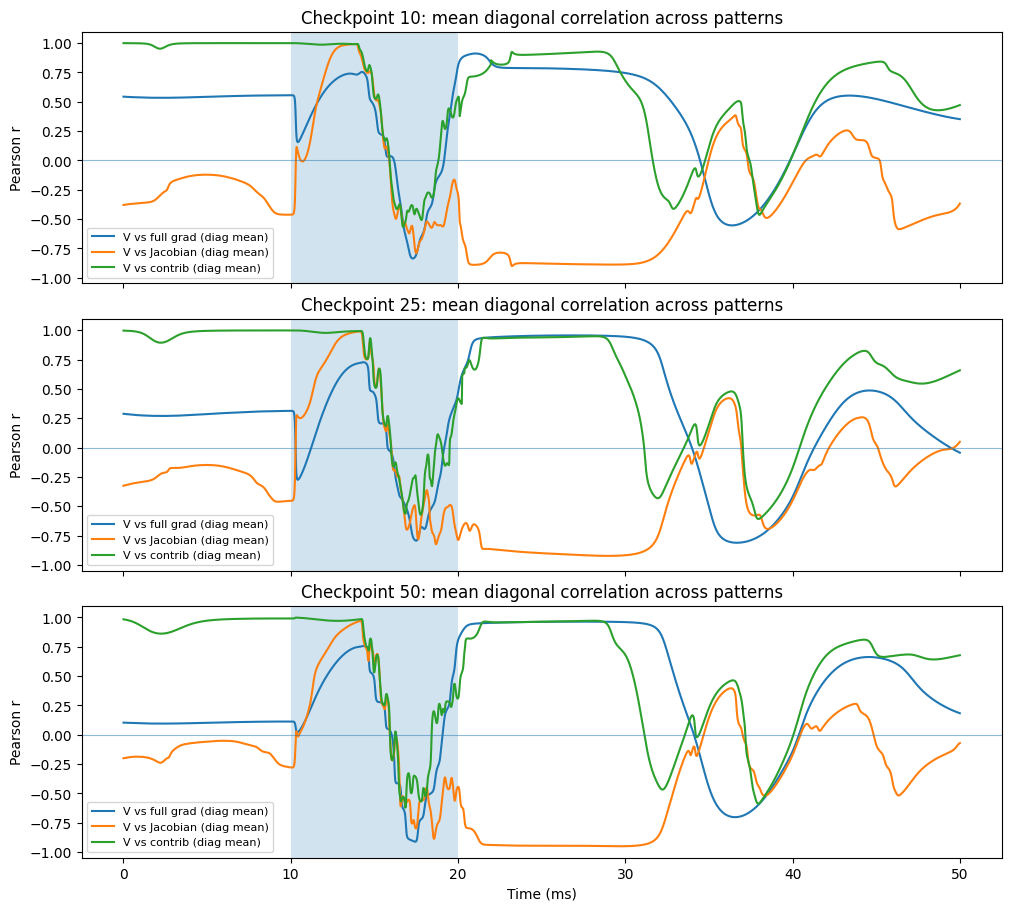

In [33]:
plot_mean_diag_over_time(R_grad_ckpt, R_J_ckpt, R_contrib_ckpt,
                         checkpoints, t_arr, i_delay, i_dur)

In [34]:
def plot_grid_p_by_i(R_ckpt_dict, checkpoints, t_arr, i_delay, i_dur,
                     title_prefix, Nsyn=8):
    for c in checkpoints:
        R = R_ckpt_dict[c]  # (p, i, t)

        fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharex=True, sharey=True,
                                 constrained_layout=True)
        axes = axes.ravel()

        for p in range(Nsyn):
            ax = axes[p]
            ax.axvspan(i_delay, i_delay + i_dur, alpha=0.2)

            for i in range(Nsyn):
                lw = 2.0 if i == p else 1.0
                ax.plot(t_arr, R[p, i, :], lw=lw, alpha=0.8)

            ax.axhline(0, lw=0.8, alpha=0.5)
            ax.set_title(f"p={p}")
            ax.set_xlabel("Time (ms)")
            ax.set_ylabel("r")

        fig.suptitle(f"{title_prefix} (checkpoint {c})", fontsize=12)
        plt.show()

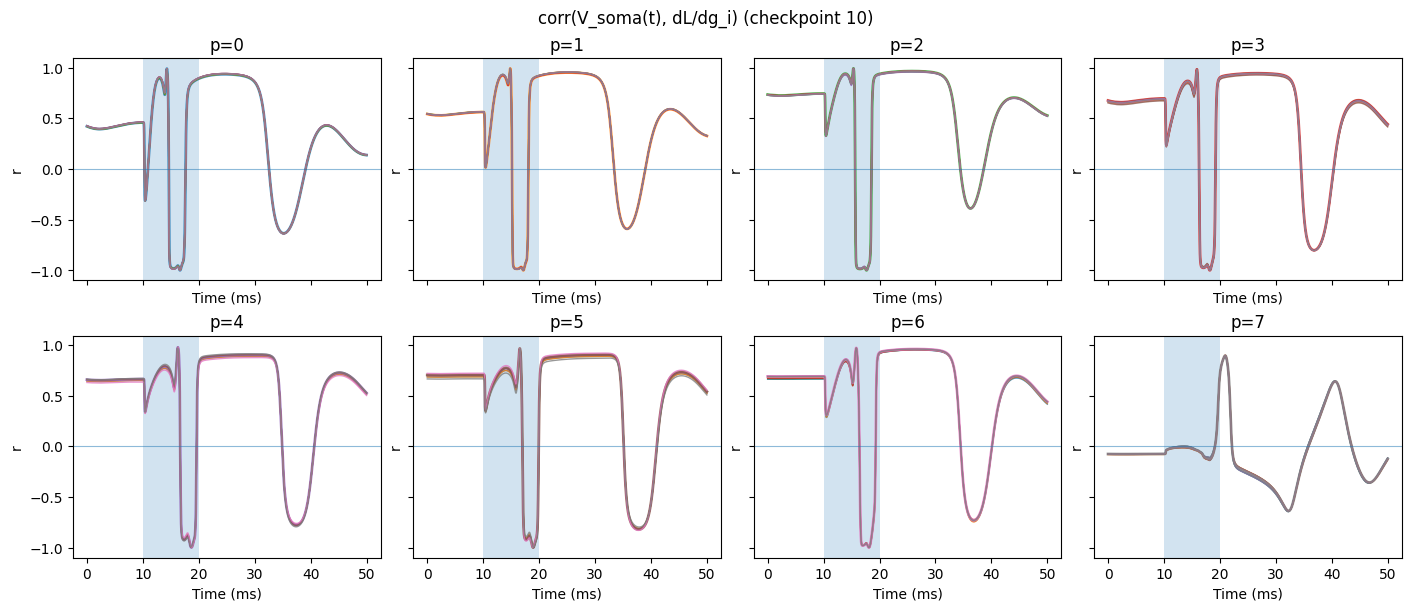

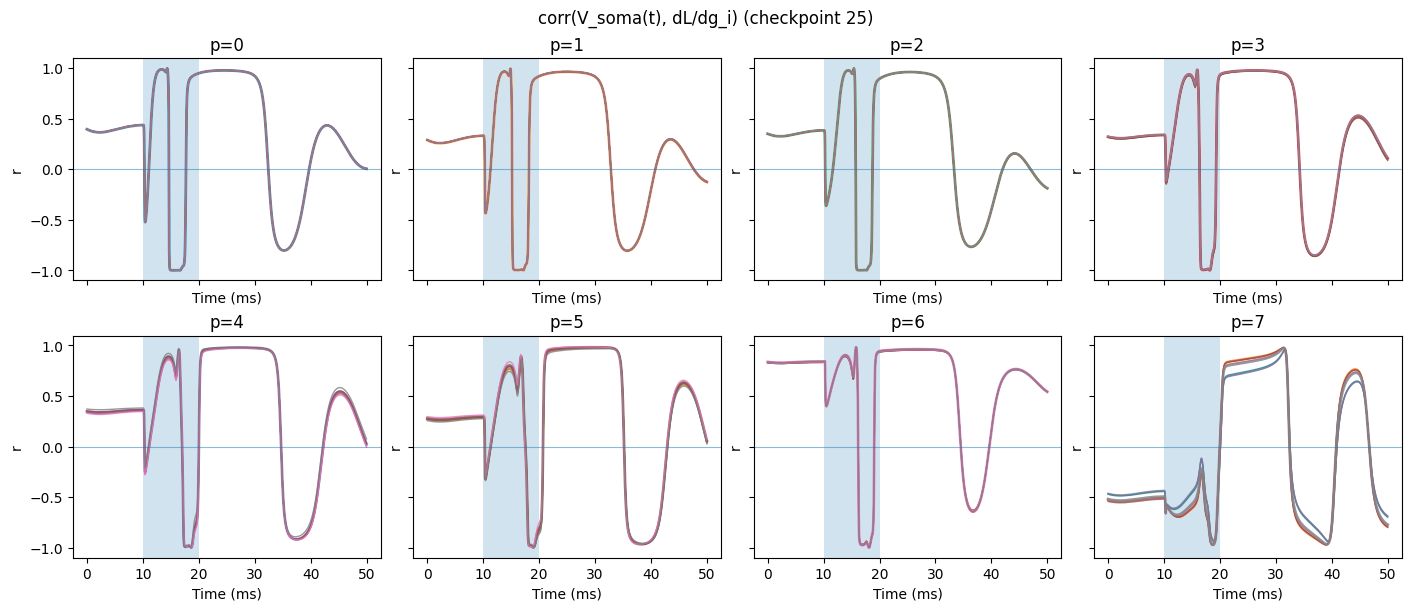

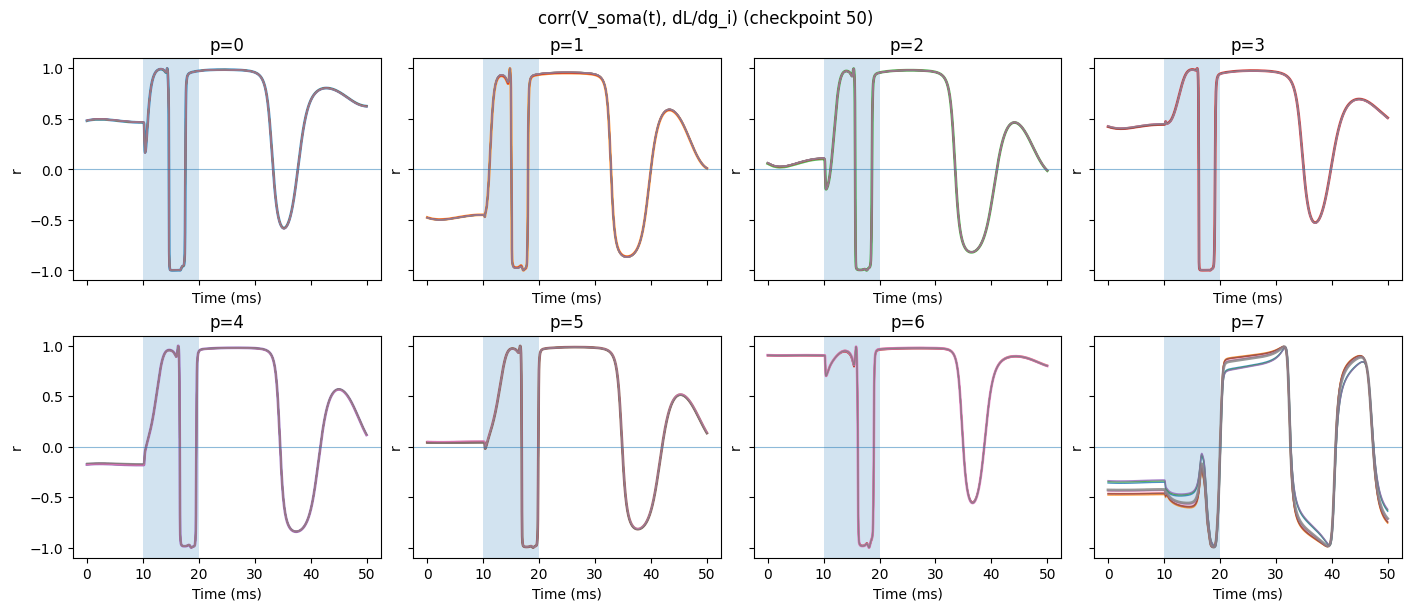

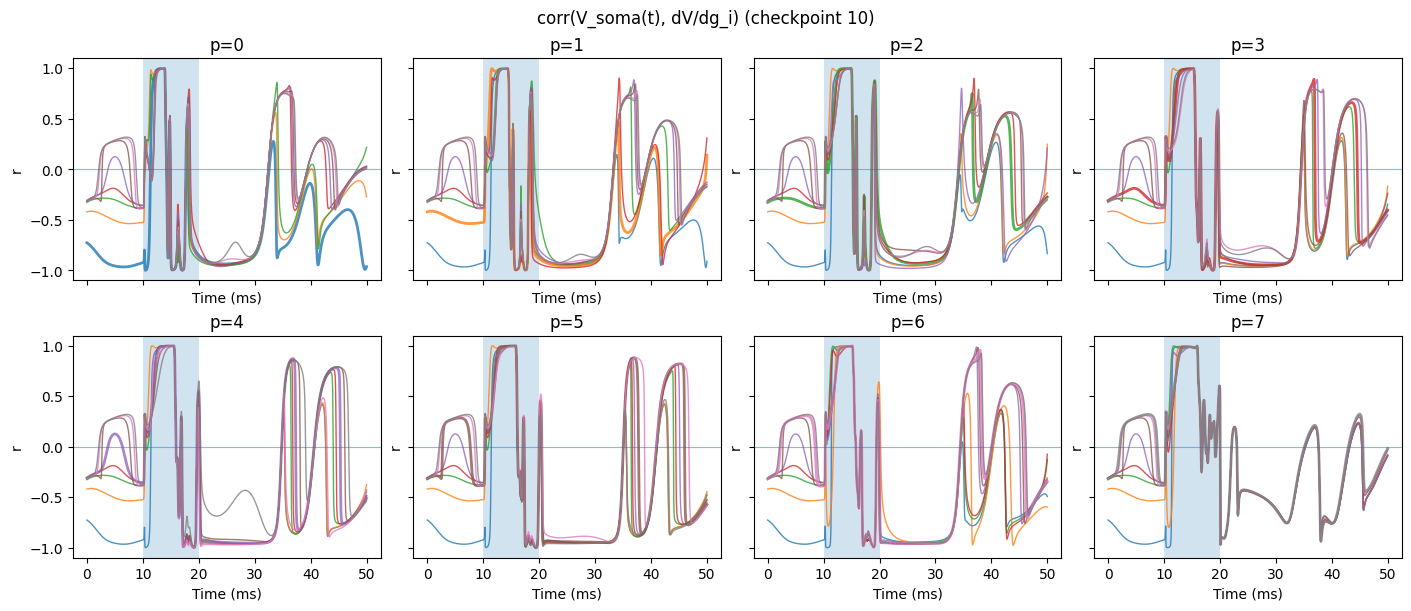

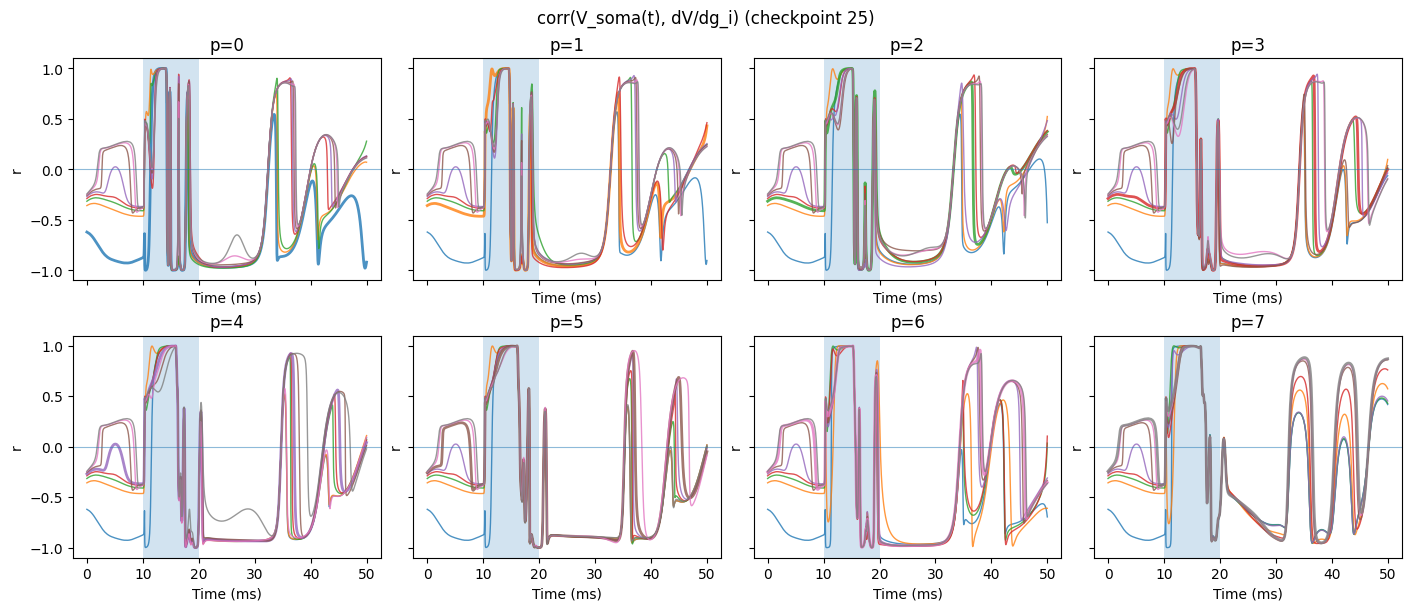

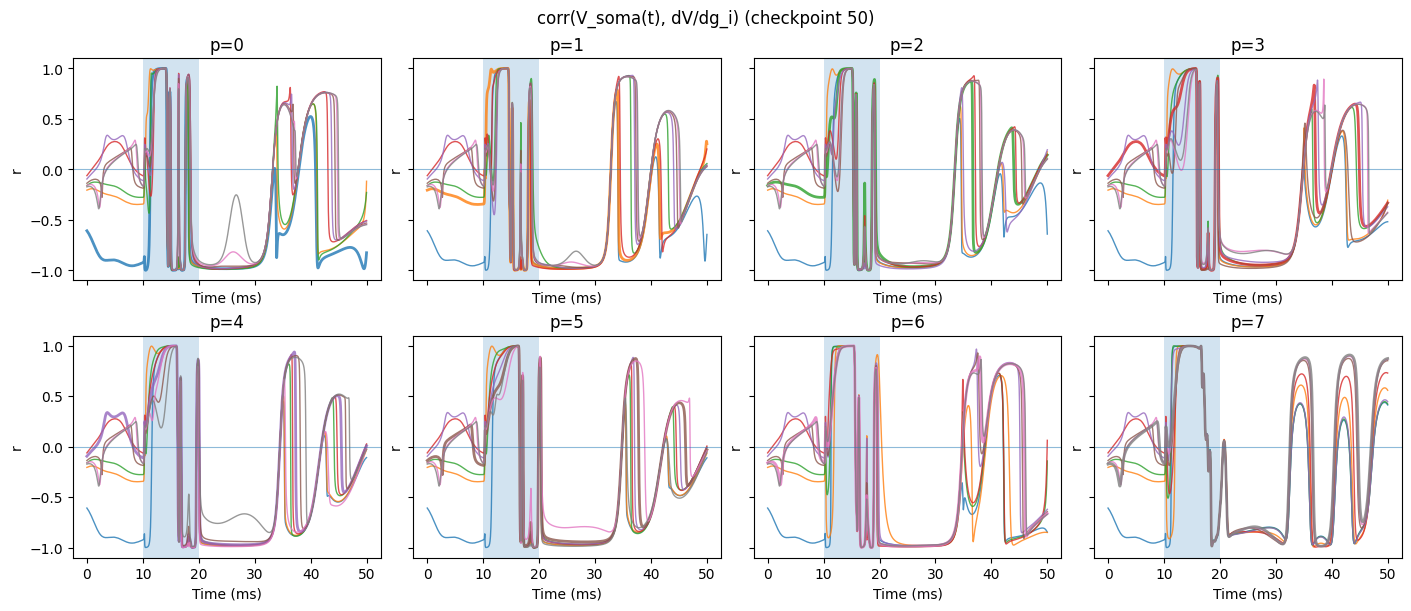

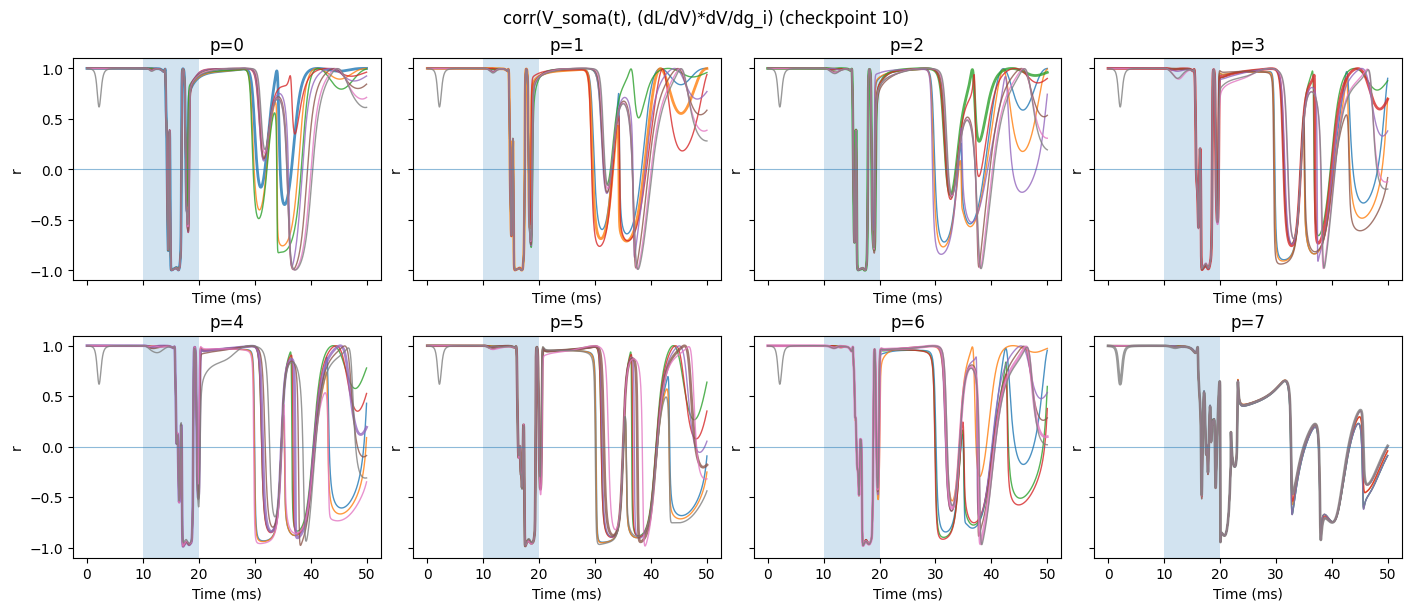

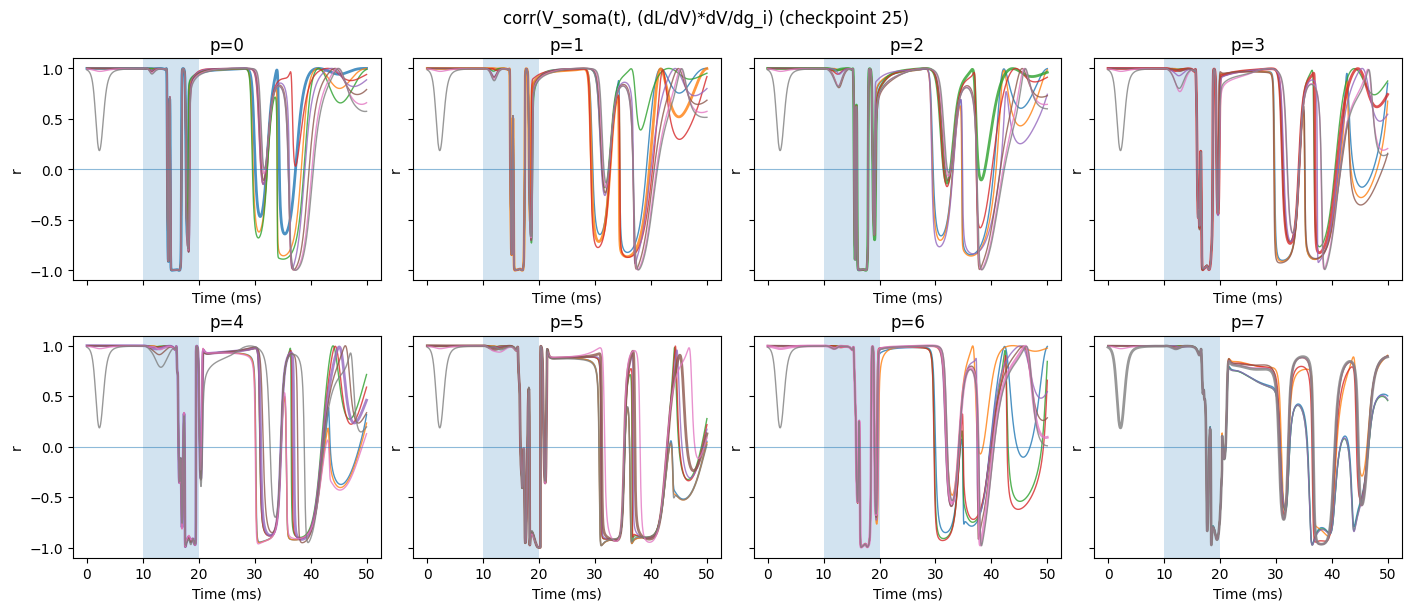

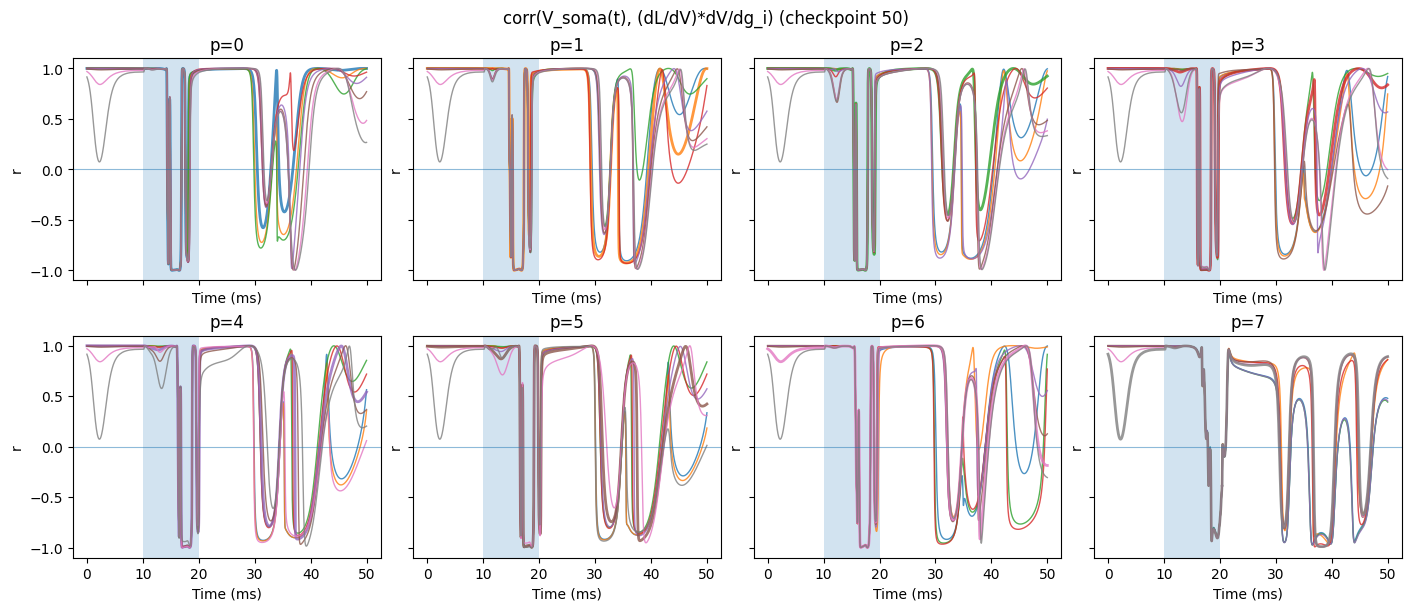

In [35]:
plot_grid_p_by_i(R_grad_ckpt, checkpoints, t_arr, i_delay, i_dur, "corr(V_soma(t), dL/dg_i)")
plot_grid_p_by_i(R_J_ckpt, checkpoints, t_arr, i_delay, i_dur, "corr(V_soma(t), dV/dg_i)")
plot_grid_p_by_i(R_contrib_ckpt, checkpoints, t_arr, i_delay, i_dur, "corr(V_soma(t), (dL/dV)*dV/dg_i)")

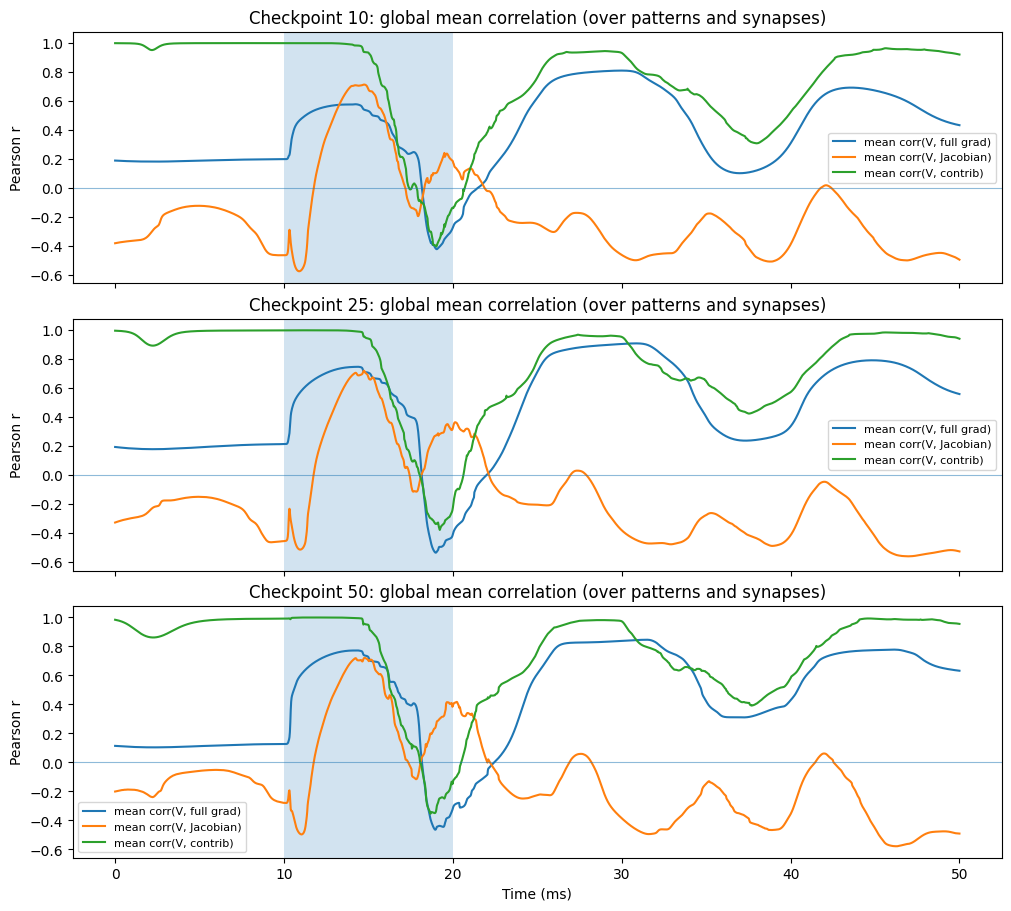

In [45]:

def plot_global_means(R_grad_ckpt, R_J_ckpt, R_contrib_ckpt, checkpoints, t_arr, i_delay, i_dur):
    fig, axes = plt.subplots(len(checkpoints), 1, figsize=(10, 3*len(checkpoints)),
                             sharex=True, sharey=True, constrained_layout=True)
    if len(checkpoints) == 1:
        axes = [axes]

    for ax, c in zip(axes, checkpoints):
        Rg = R_grad_ckpt[c]      # (P, i, t)
        RJ = R_J_ckpt[c]
        Rc = R_contrib_ckpt[c]

        m_g = Rg.mean(axis=(0, 1))   # (t,)
        m_J = RJ.mean(axis=(0, 1))
        m_c = Rc.mean(axis=(0, 1))

        ax.axvspan(i_delay, i_delay + i_dur, alpha=0.2)
        ax.plot(t_arr, m_g, lw=1.5, label="mean corr(V, full grad)")
        ax.plot(t_arr, m_J, lw=1.5, label="mean corr(V, Jacobian)")
        ax.plot(t_arr, m_c, lw=1.5, label="mean corr(V, contrib)")
        ax.axhline(0, lw=0.8, alpha=0.5)
        ax.set_title(f"Checkpoint {c}: global mean correlation (over patterns and synapses)")
        ax.set_ylabel("Pearson r")
        ax.legend(fontsize=8)

    axes[-1].set_xlabel("Time (ms)")
    plt.show()

plot_global_means(R_grad_ckpt, R_J_ckpt, R_contrib_ckpt, checkpoints, t_arr, i_delay, i_dur)

In [40]:
for c in checkpoints:
    print("ckpt", c,
          "VALL", VALL_ckpt[c].shape,
          "GRADS", GRADS_ckpt[c].shape,
          "JALL", JALL_ckpt[c].shape,
          "LOSS", LOSS_ckpt[c].shape)

ckpt 10 VALL (30, 56, 8, 2001) GRADS (30, 56, 8) JALL (30, 56, 2001, 8) LOSS (30, 56)
ckpt 25 VALL (30, 56, 8, 2001) GRADS (30, 56, 8) JALL (30, 56, 2001, 8) LOSS (30, 56)
ckpt 50 VALL (30, 56, 8, 2001) GRADS (30, 56, 8) JALL (30, 56, 2001, 8) LOSS (30, 56)


In [39]:
P = patterns_probe.shape[0]
print("P:", P, "Nsyn:", Nsyn, "T_keep:", T_keep)
for c in checkpoints:
    print(c, R_grad_ckpt[c].shape, R_J_ckpt[c].shape, R_contrib_ckpt[c].shape)
# expected: (56, 8, T_keep)

P: 56 Nsyn: 8 T_keep: 2001
10 (8, 8, 2001) (8, 8, 2001) (8, 8, 2001)
25 (8, 8, 2001) (8, 8, 2001) (8, 8, 2001)
50 (8, 8, 2001) (8, 8, 2001) (8, 8, 2001)


In [41]:

def corr_over_seeds(X, y, eps=1e-12):
    # X: (S, T_keep), y: (S,)
    Xc = X - X.mean(axis=0, keepdims=True)
    yc = y - y.mean()
    num = (Xc * yc[:, None]).sum(axis=0)
    den = np.sqrt((Xc**2).sum(axis=0) * (yc**2).sum() + eps)
    return num / den

def corr_pair_over_seeds(X, Y, eps=1e-12):
    # X, Y: (S, T_keep)
    Xc = X - X.mean(axis=0, keepdims=True)
    Yc = Y - Y.mean(axis=0, keepdims=True)
    num = (Xc * Yc).sum(axis=0)
    den = np.sqrt((Xc**2).sum(axis=0) * (Yc**2).sum(axis=0) + eps)
    return num / den

P = patterns_probe.shape[0]  # 56

R_grad_ckpt = {}
R_J_ckpt = {}
R_contrib_ckpt = {}

for c in checkpoints:
    Vraw = VALL_ckpt[c]   # (S, P, n_sites, T_keep)
    G    = GRADS_ckpt[c]  # (S, P, Nsyn)
    Jraw = JALL_ckpt[c]   # (S, P, T_keep, Nsyn)

    R_grad = np.zeros((P, Nsyn, T_keep), dtype=np.float32)
    R_J    = np.zeros((P, Nsyn, T_keep), dtype=np.float32)
    R_con  = np.zeros((P, Nsyn, T_keep), dtype=np.float32)

    for p in range(P):
        V_soma = Vraw[:, p, 0, :]                    # (S, T_keep)
        tgt    = np.asarray(targets_probe[p])        # (T_keep,)
        dL_dV  = (2.0 / T_keep) * (V_soma - tgt[None, :])  # (S, T_keep)

        for i in range(Nsyn):
            g_pi = G[:, p, i]                        # (S,)
            R_grad[p, i, :] = corr_over_seeds(V_soma, g_pi).astype(np.float32)

            Ji = Jraw[:, p, :, i]                    # (S, T_keep)
            R_J[p, i, :] = corr_pair_over_seeds(V_soma, Ji).astype(np.float32)

            contrib = dL_dV * Ji
            R_con[p, i, :] = corr_pair_over_seeds(V_soma, contrib).astype(np.float32)

    R_grad_ckpt[c] = R_grad
    R_J_ckpt[c] = R_J
    R_contrib_ckpt[c] = R_con

print("P:", P, "Nsyn:", Nsyn, "T_keep:", T_keep)
for c in checkpoints:
    print(c, R_grad_ckpt[c].shape, R_J_ckpt[c].shape, R_contrib_ckpt[c].shape)
# expect: (56, 8, 2001)

P: 56 Nsyn: 8 T_keep: 2001
10 (56, 8, 2001) (56, 8, 2001) (56, 8, 2001)
25 (56, 8, 2001) (56, 8, 2001) (56, 8, 2001)
50 (56, 8, 2001) (56, 8, 2001) (56, 8, 2001)


In [1]:
def plot_active_vs_inactive(R_ckpt_dict, patterns_probe, checkpoints, t_arr, i_delay, i_dur,
                            title, synapses=None):
    P, N = patterns_probe.shape
    if synapses is None:
        synapses = list(range(N))

    # boolean mask: active[p, i] = whether synapse i is ON in pattern p
    active = np.asarray(patterns_probe) > 0.5  # (P, N)

    for c in checkpoints:
        R = np.asarray(R_ckpt_dict[c])  # (P, N, T)
        fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharex=True, sharey=True,
                                 constrained_layout=True)
        axes = axes.ravel()

        for idx, i in enumerate(synapses):
            ax = axes[idx]
            ax.axvspan(i_delay, i_delay + i_dur, alpha=0.2)

            on_mask = active[:, i]          # (P,)
            off_mask = ~active[:, i]

            # Average corr over patterns where i is on/off, for that same synapse i
            on_mean  = R[on_mask,  i, :].mean(axis=0)
            off_mean = R[off_mask, i, :].mean(axis=0)

            ax.plot(t_arr, on_mean,  lw=1.5, label="i in pattern")
            ax.plot(t_arr, off_mean, lw=1.5, label="i not in pattern")
            ax.axhline(0, lw=0.8, alpha=0.5)

            ax.set_title(f"synapse i={i}")
            ax.set_xlabel("Time (ms)")
            ax.set_ylabel("r")
            if idx == 0:
                ax.legend(fontsize=8)

        fig.suptitle(f"{title} — active vs inactive patterns (checkpoint {c})", fontsize=12)
        plt.show()

plot_active_vs_inactive(R_grad_ckpt, patterns_probe, checkpoints, t_arr, i_delay, i_dur,
                        "corr(V_soma(t), dL/dg_i)")

plot_active_vs_inactive(R_J_ckpt, patterns_probe, checkpoints, t_arr, i_delay, i_dur,
                        "corr(V_soma(t), dV/dg_i)")

plot_active_vs_inactive(R_contrib_ckpt, patterns_probe, checkpoints, t_arr, i_delay, i_dur,
                        "corr(V_soma(t), (dL/dV)*dV/dg_i)")

NameError: name 'R_grad_ckpt' is not defined

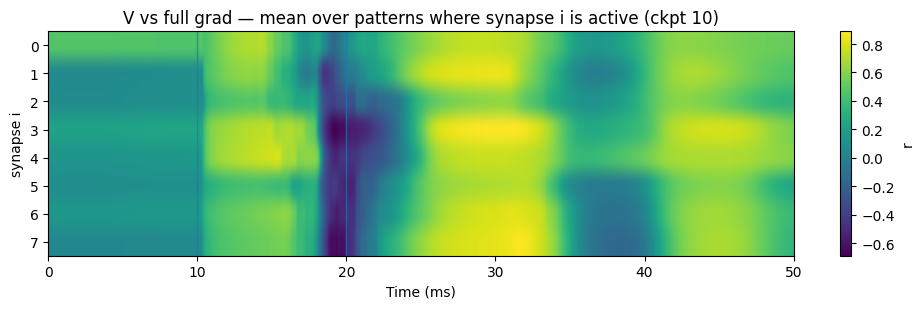

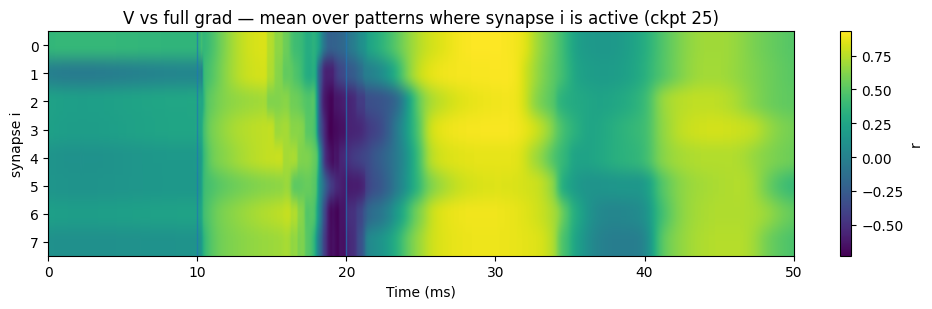

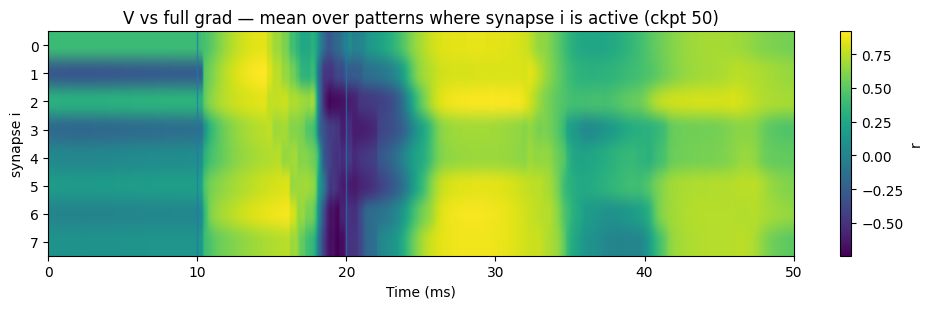

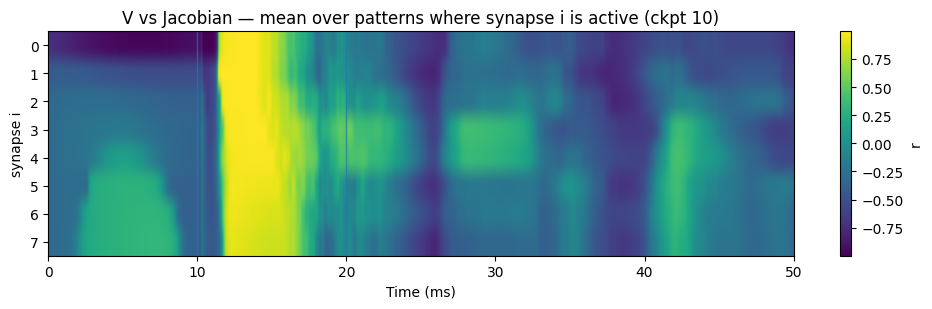

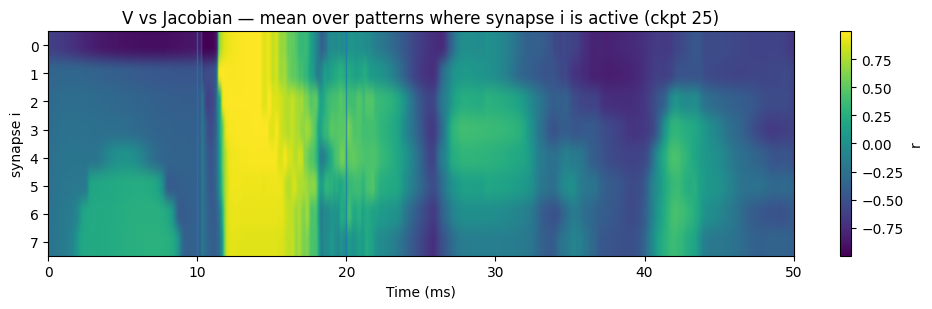

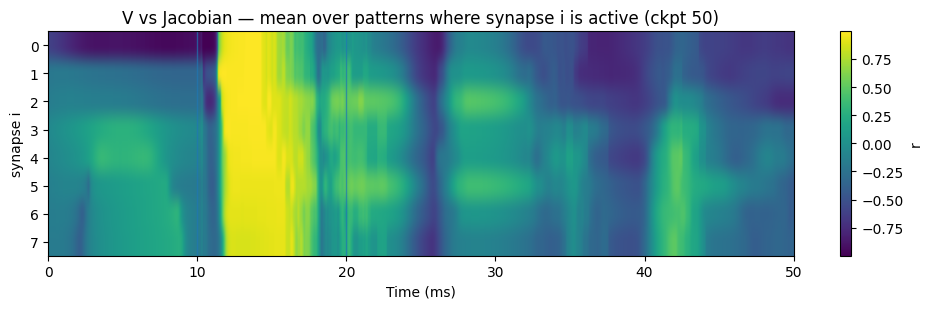

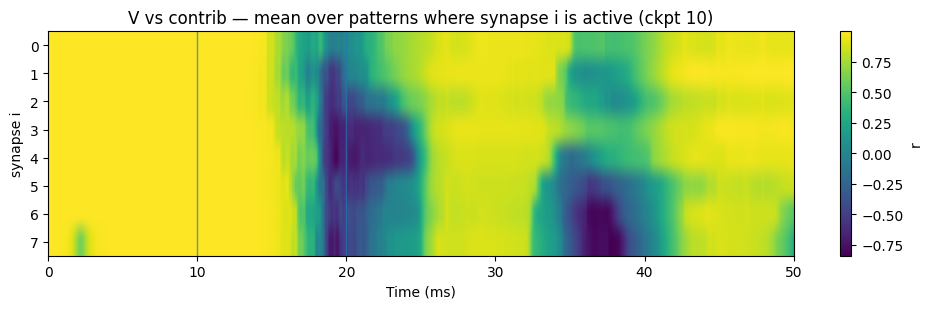

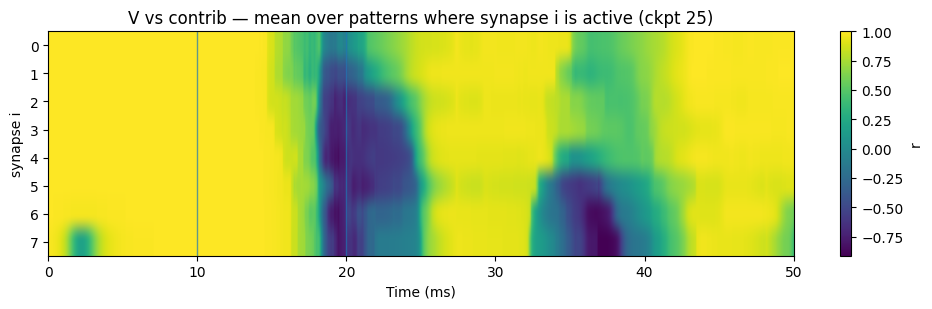

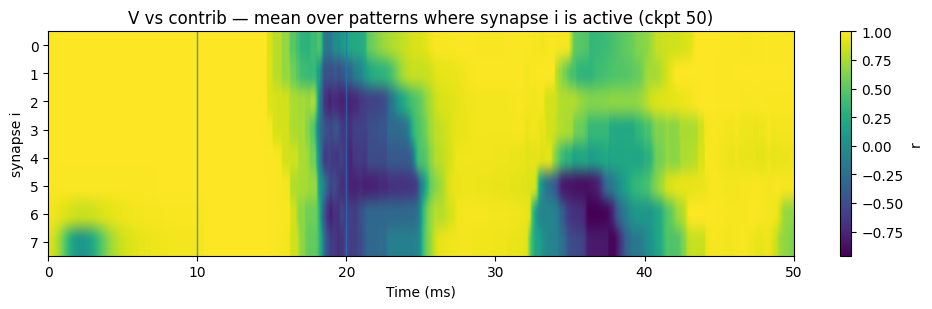

In [43]:
def plot_active_mean_heatmap(R_ckpt_dict, patterns_probe, checkpoints, t_arr, i_delay, i_dur, title):
    active = np.asarray(patterns_probe) > 0.5  # (P, Nsyn)

    for c in checkpoints:
        R = np.asarray(R_ckpt_dict[c])  # (P, Nsyn, T_keep)
        M = np.zeros((Nsyn, T_keep), dtype=np.float32)

        for i in range(Nsyn):
            mask = active[:, i]
            M[i, :] = R[mask, i, :].mean(axis=0)

        fig, ax = plt.subplots(figsize=(10, 3.2))
        im = ax.imshow(M, aspect="auto",
                       extent=[t_arr[0], t_arr[-1], Nsyn-0.5, -0.5])
        ax.axvline(i_delay, lw=1, alpha=0.7)
        ax.axvline(i_delay + i_dur, lw=1, alpha=0.7)
        ax.set_yticks(range(Nsyn))
        ax.set_xlabel("Time (ms)")
        ax.set_ylabel("synapse i")
        ax.set_title(f"{title} — mean over patterns where synapse i is active (ckpt {c})")
        plt.colorbar(im, ax=ax, label="r")
        plt.tight_layout()
        plt.show()

plot_active_mean_heatmap(R_grad_ckpt, patterns_probe, checkpoints, t_arr, i_delay, i_dur,
                         "V vs full grad")

plot_active_mean_heatmap(R_J_ckpt, patterns_probe, checkpoints, t_arr, i_delay, i_dur,
                         "V vs Jacobian")

plot_active_mean_heatmap(R_contrib_ckpt, patterns_probe, checkpoints, t_arr, i_delay, i_dur,
                         "V vs contrib")